In [1]:
import sys,os
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import vaex
import astropy.units as u
from math import ceil
import reverse_indices_2d as ri
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import ascii
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline as spline
import cmasher as cm

%matplotlib inline

In [211]:
run ../scripts/rc_params.py

rcParams updated :)


<Figure size 504x504 with 0 Axes>

In [3]:
#Create a dataframe of PHATTER sources
#First cut to the data is GST criteria for the IR filters

phatter = vaex.open('/Users/tatianasandford/Documents/Research/M33/M33_full_matched.hdf5')
phatter.select('(F110W_SNR > 4) & (F110W_SHARP**2 < 0.15) & '
          '(F110W_CROWD < 2.25) & '
          '(F160W_SNR > 4) & (F160W_SHARP**2 < 0.15) & '
          '(F160W_CROWD < 2.25)', name='IR_GST')

In [4]:
#Add index to PHATTER dataframe
phatter['INDEX'] = np.arange(len(phatter))
###Add 110-160 color column to dataframe for convenience
phatter['F110W_F160W'] = phatter['F110W_VEGA'] - phatter['F160W_VEGA']

In [5]:
# Set the aspect ratio for any ra/dec plot of M33

ra_max, ra_min = phatter.RA.max(selection='IR_GST'), phatter.RA.min(selection='IR_GST')
dec_max, dec_min = phatter.DEC.max(selection='IR_GST'), phatter.DEC.min(selection='IR_GST')
dec_m33 = phatter.DEC.mean()

m33_ar = (dec_max - dec_min) / ((ra_max - ra_min)*np.cos(np.pi/180.*dec_m33))

In [6]:
#Extract index RA and DEC  with GST cuts for easy plotting later
index_gst = phatter.INDEX.evaluate(selection='IR_GST')
ra_gst, dec_gst = phatter.RA.evaluate(selection='IR_GST'), phatter.DEC.evaluate(selection='IR_GST')

In [7]:
print('Coordinate Span of PHATTER footprint')
print('RA (deg): {:.4f} - {:.4f}'.format(ra_min, ra_max))
print('DEC (deg): {:.4f} - {:.4f}'.format(dec_min, dec_max))

Coordinate Span of PHATTER footprint
RA (deg): 23.3422 - 23.6613
DEC (deg): 30.4894 - 30.8491


In [8]:
#Create a table of unWISE sources within the PHATTER footprint

Irsa.ROW_LIMIT = 100000
wise = Irsa.query_region("m33", catalog="unwise_2019", spatial="Polygon",
            polygon=[SkyCoord(ra=23.341,dec=30.488,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.662,dec=30.488,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.662,dec=30.85,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.341,dec=30.85,unit=(u.deg,u.deg),frame='icrs')])

wise[:2]

<Table length=2>
  unwise_objid        ra      ...   unwise_detid_1     unwise_detid_2  
                     deg      ...                                      
     object        float64    ...       object             object      
---------------- ------------ ... ------------------ ------------------
0243p302o0017123  23.62794233 ... 0243p302w1o0027393 0243p302w2o0016553
0243p302o0017136  23.63701125 ... 0243p302w1o0027419 0243p302w2o0016565

In [9]:
#Cut any unWISE source with the flag 'primary' not equal to 1
#This will elminate duplicate sources
dup_cut, = np.where(wise['primary'] == 1)

#Convert entries with no W1 flux measurement to 0.0
uw = wise.filled(fill_value=0.0)

#Define the culled dataframe
unwise = uw[dup_cut][uw[dup_cut]['flux_1'] != 0]

In [10]:
w2, = np.where(unwise['flux_2'] != 0.0)

In [11]:
len(unwise), len(unwise[w2])

(2598, 1536)

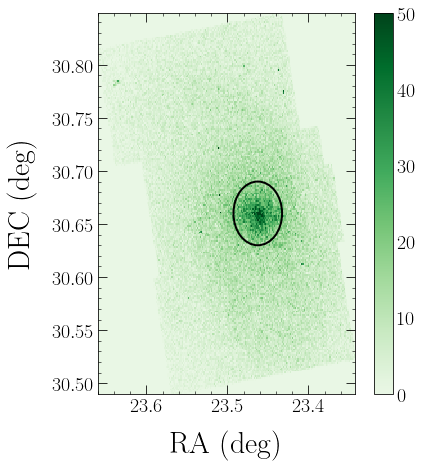

In [12]:
fig, ax = plt.subplots(1)

plt.rcParams["axes.axisbelow"] = False

cmap = cm.get_sub_cmap('Greens', 0.1, 1.0)

qc, = np.where(phatter.F160W_VEGA.evaluate(selection='IR_GST') <= 20)
plot = ax.hist2d(ra_gst[qc], dec_gst[qc],
                 bins=200,
                 cmap=cmap,
                 vmax=50
                 
                
                );
ctr = patches.Circle((23.4625, 30.66), radius=0.03, edgecolor='black', facecolor=(0,0,0,0), linewidth=2)
ax.add_patch(ctr)

ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')
ax.set_aspect(m33_ar)
ax.invert_xaxis()

cbar = plt.colorbar(plot[3]);
cbar.ax.tick_params(which='both', length=0);

plt.savefig('./images/ctr_cutout.png', bbox_inches='tight')

In [13]:
distance = np.sqrt( ((unwise['ra'] - 23.4625)*np.cos(30.66 * np.pi / 180))**2 + 
               (unwise['dec'] - 30.66)**2)
outside, = np.where(distance >= 0.03)
unwise = unwise[outside]

#Add an index to more easily reference specific sources
unwise['index'] = np.arange(0, len(unwise), 1)

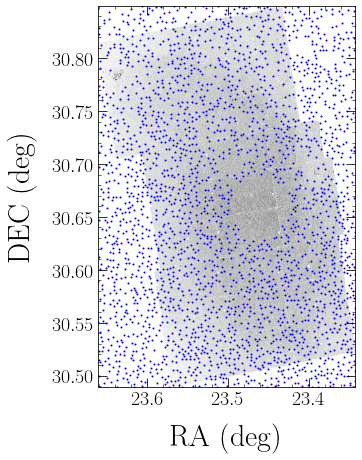

In [14]:
#sanity check

fig, ax = plt.subplots(1)

ax.hist2d(ra_gst, dec_gst,
                 bins=300,
                 cmap='Greys',
                 vmax=500,
                
                );

ax.scatter(unwise['ra'], unwise['dec'],
                  s=1,
                  c='blue'
                );
ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')
ax.set_aspect(m33_ar)
ax.invert_xaxis()

In [15]:
#Converts flux measurements to vega magnitude, valid for W1 and W2
#Conversion from 'The unWISE Catalog: Two Billion Infrared Sources from Five Years of WISE Imaging'
#DOI 10.3847/1538-4365/aafbea

def unwise_to_mag(flux):
  mag = 22.5 - 2.5 * np.log10(flux)
  return mag

In [16]:
#For sources with W2 flux measurements, convert flux to W2 magnitude

w2_mags = []

for source in unwise['flux_2']:
    if source != 0.0:
        mag = unwise_to_mag(source)
    else:
        mag = -9999.999
    
    w2_mags.append(mag)

In [17]:
#Add columns to data with W1 and W2 (where available) magnitudes

unwise['w1_mag'] = unwise_to_mag(unwise['flux_1'])
#unwise['w2_mag'] = w2_mags

## Check Very Bright WISE Stars

In [18]:
ex_mw, = np.where(unwise['flux_1'] < 10000)

In [19]:
#WISE sources W1 flux median, mean, std, & maximm
np.median(unwise['flux_1']).round(), np.mean(unwise['flux_1']).round(), np.std(unwise['flux_1']).round(), np.max(unwise['flux_1'])

(680.0, 1480.0, 5383.0, 184030.0)

In [20]:
mw, = np.where(unwise['flux_1'] >= 10000)

In [21]:
unwise_to_mag(10000)

12.5

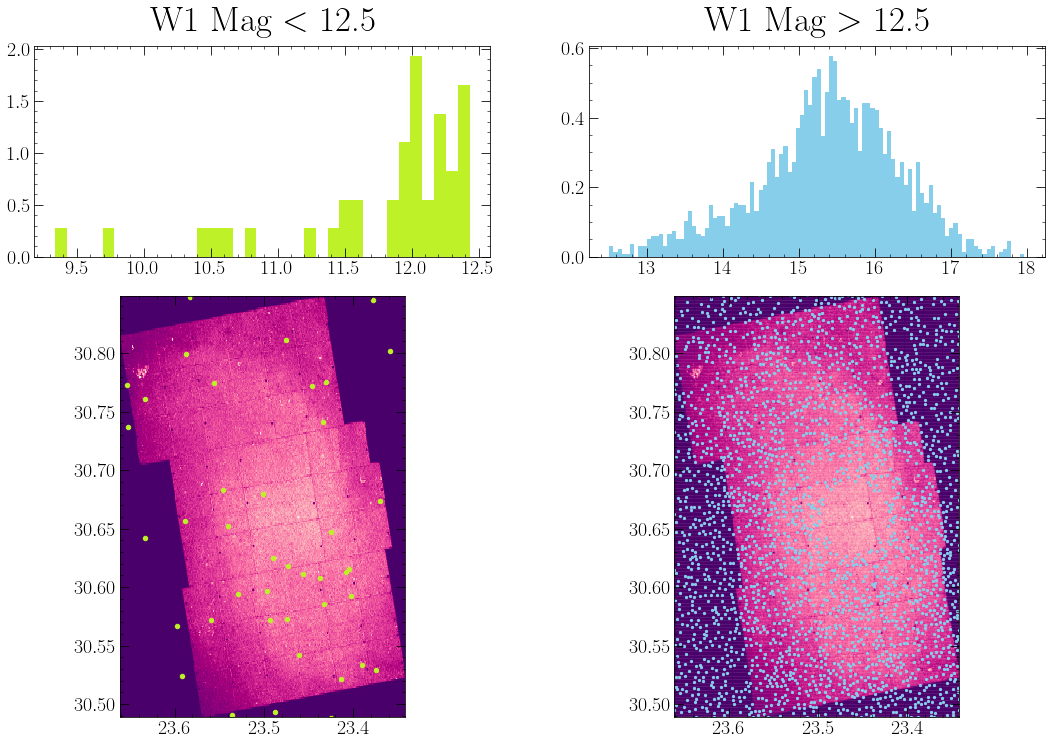

In [22]:
fig, ax = plt.subplots(2,2, gridspec_kw={'width_ratios': [1,1], 'height_ratios': [1,2]})
fig.set_size_inches(15,10)
fig.tight_layout(w_pad=5)

ax[0,0].hist(unwise['w1_mag'][mw], 
             bins=35, density=True,
             color='xkcd:yellowy green')
ax[0,0].set_title('W1 Mag $<$ 12.5')
ax[0,1].hist(unwise['w1_mag'][ex_mw], 
             bins=100, density=True,
             color='skyblue');
ax[0,1].set_title('W1 Mag $>$ 12.5')

ax[1,0].set_aspect(m33_ar)
ax[1,0].hist2d(ra_gst,dec_gst, bins=300)
ax[1,0].scatter(unwise['ra'][mw], unwise['dec'][mw], s=20, c='xkcd:yellowy green')
ax[1,0].invert_xaxis()

ax[1,1].set_aspect(m33_ar)
ax[1,1].hist2d(ra_gst,dec_gst, bins=300, alpha=0.7)
ax[1,1].scatter(unwise['ra'][ex_mw], unwise['dec'][ex_mw], s=5, color='skyblue');
ax[1,1].invert_xaxis();

In [23]:
unwise['w2_mag'] = unwise_to_mag(unwise['flux_2'])

<ipython-input-15-769e318a72f3>:6: RuntimeWarning: divide by zero encountered in log10
  mag = 22.5 - 2.5 * np.log10(flux)


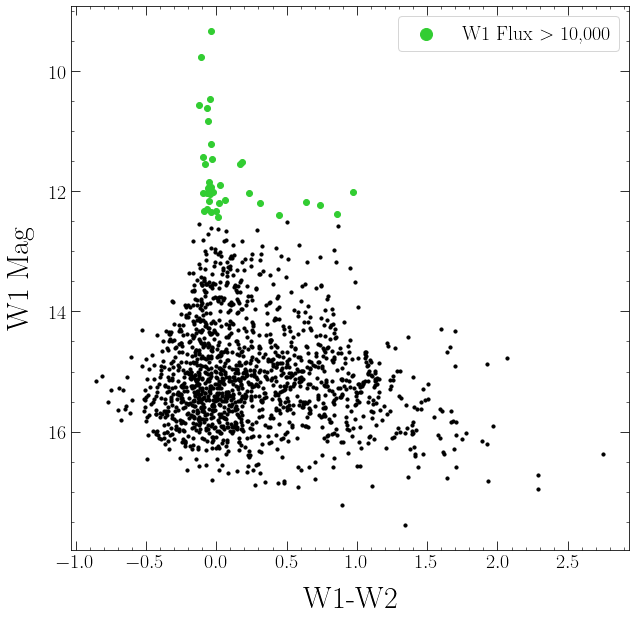

In [24]:
###Look at where these stars lie on a CMD

fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)

ax.scatter(unwise['w1_mag'] - unwise['w2_mag'], unwise['w1_mag'], s=10, c='black')
ax.scatter(unwise['w1_mag'][mw] - unwise['w2_mag'][mw], unwise['w1_mag'][mw], c='limegreen', label='W1 Flux $>$ 10,000')
ax.invert_yaxis()
ax.set_xlabel('W1-W2')
ax.set_ylabel('W1 Mag')
ax.legend();

# Color Conversion

In [25]:
#lmc_raw = ascii.read('./irsa_lmc.csv',
#                 names=('des', 'ra', 'dec', 'w1', 'w1snr', 'w2', 'w2snr', 'w3', 'w3snr', 'w4', 'w4snr', 'pmra', 'pmdec', 'unc_pmdec', 'j', 'h')
#                  
#                 )

In [26]:
lmc_raw = ascii.read('./wide_lmc.csv',
                    names=('ra', 'dec', 'w1', 'w1snr', 'w2', 'w2snr', 'w3', 'w3snr', 'w4', 'w4snr', 'pmra', 'pmdec', 'j', 'h'))

In [27]:
#lmc_raw.remove_columns(['des', 'w3', 'w3snr', 'w4', 'w4snr', 'unc_pmdec'])
lmc_raw.remove_columns(['w3', 'w3snr', 'w4', 'w4snr'])

In [28]:
lmc_raw[:3]

<Table length=3>
    ra         dec       w1   w1snr   w2   w2snr pmra pmdec   j      h   
 float64     float64    str6   str5  str6   str6 str7  str7  str6   str6 
---------- ----------- ------ ----- ------ ----- ---- ----- ------ ------
69.1498968 -68.7866827 15.832  29.3 15.822  12.8  234    83   null   null
68.7776213 -68.7634378 15.914  28.2 15.764  14.0 -211   291   null   null
68.6955753 -68.8463027 15.035  37.4 15.152  21.4  327    58 15.986 15.134

In [29]:
not_null, = np.where((lmc_raw['w1'] != 'null') & 
                     (lmc_raw['w1snr'] != 'null')& 
                     (lmc_raw['w2'] != 'null')& 
                     (lmc_raw['w2snr'] != 'null')& 
                     (lmc_raw['pmra'] != 'null')& 
                     (lmc_raw['pmdec'] != 'null')& 
                     (lmc_raw['j'] != 'null')& 
                     (lmc_raw['h'] != 'null')
                    )
lmc_raw = lmc_raw[not_null]

In [30]:
names = ['w1', 'w1snr', 'w2', 'w2snr', 'pmra', 'pmdec', 'j', 'h']
for name in names:
    lmc_raw[name] = lmc_raw[name].astype(float)

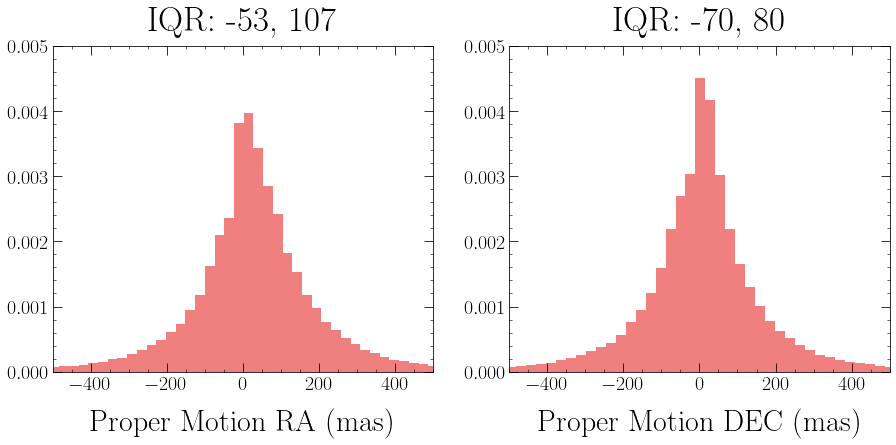

In [31]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,6)

rstd = np.percentile(lmc_raw['pmra'], [25,75])
dstd = np.percentile(lmc_raw['pmdec'], [25,75])

ax[0].hist(lmc_raw['pmra'], bins=10000, density=True);
ax[0].set_xlim(-500,500)
ax[0].set_ylim(0.0, 0.005)
ax[0].set_xlabel('Proper Motion RA (mas)')
ax[0].set_title(f"IQR: {rstd[0]:.0f}, {rstd[1]:.0f}")

ax[1].hist(lmc_raw['pmdec'], bins=10000, density=True);
ax[1].set_xlim(-500,500)
ax[1].set_ylim(0.0, 0.005)
ax[1].set_xlabel('Proper Motion DEC (mas)');
ax[1].set_title(f"IQR: {dstd[0]:.0f}, {dstd[1]:.0f}");


In [32]:
not_mw, = np.where((lmc_raw['pmra'] > -50) & (lmc_raw['pmra'] < 50) & 
                   (lmc_raw['pmdec'] > -50) & (lmc_raw['pmdec'] < 50)
                  )

In [33]:
lmc_pm = lmc_raw[not_mw]

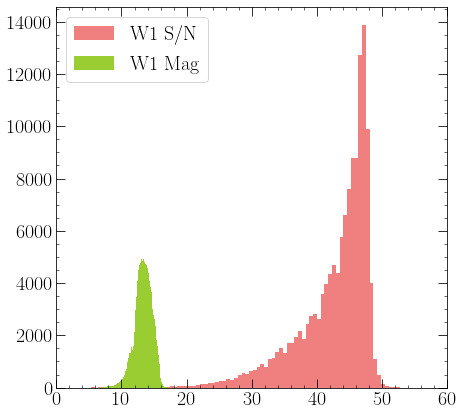

In [34]:
plt.hist(lmc_pm['w1snr'], bins=100, label='W1 S/N');
plt.hist(lmc_pm['w1'], bins=100, label='W1 Mag');
plt.xlim(0,60)
plt.legend(loc='best');

In [35]:
bright, = np.where(lmc_pm['w1'] < 11)

In [36]:
sharp, = np.where(lmc_pm[bright]['w1snr'] > 40)

In [37]:
lmc = lmc_pm[bright][sharp]
j, h, w1 = lmc['j'], lmc['h'], lmc['w1']

In [38]:
jh = j-h
hw1 = h-w1

In [39]:
bins = 300
lmc_hist = np.histogram2d(jh, hw1, bins=bins)

In [40]:
windows = [hw1[np.where((jh >= lmc_hist[1][i]) 
                            & (jh < lmc_hist[1][i+1]))] 
           for i in range(len(lmc_hist[1]) -1)]

In [41]:
running_mean = []
nz = []
for i in range(bins):
    window = hw1[np.where((jh >= lmc_hist[1][i]) 
                            & (jh < lmc_hist[1][i+1]))]
    if window.size > 2:
        iqr = np.percentile(window, [25,75])
        keep = np.where((window >= iqr[0]) & (window <= iqr[1]))
        mean = np.mean(window[keep])
        running_mean.append(mean)
        nz.append(i)

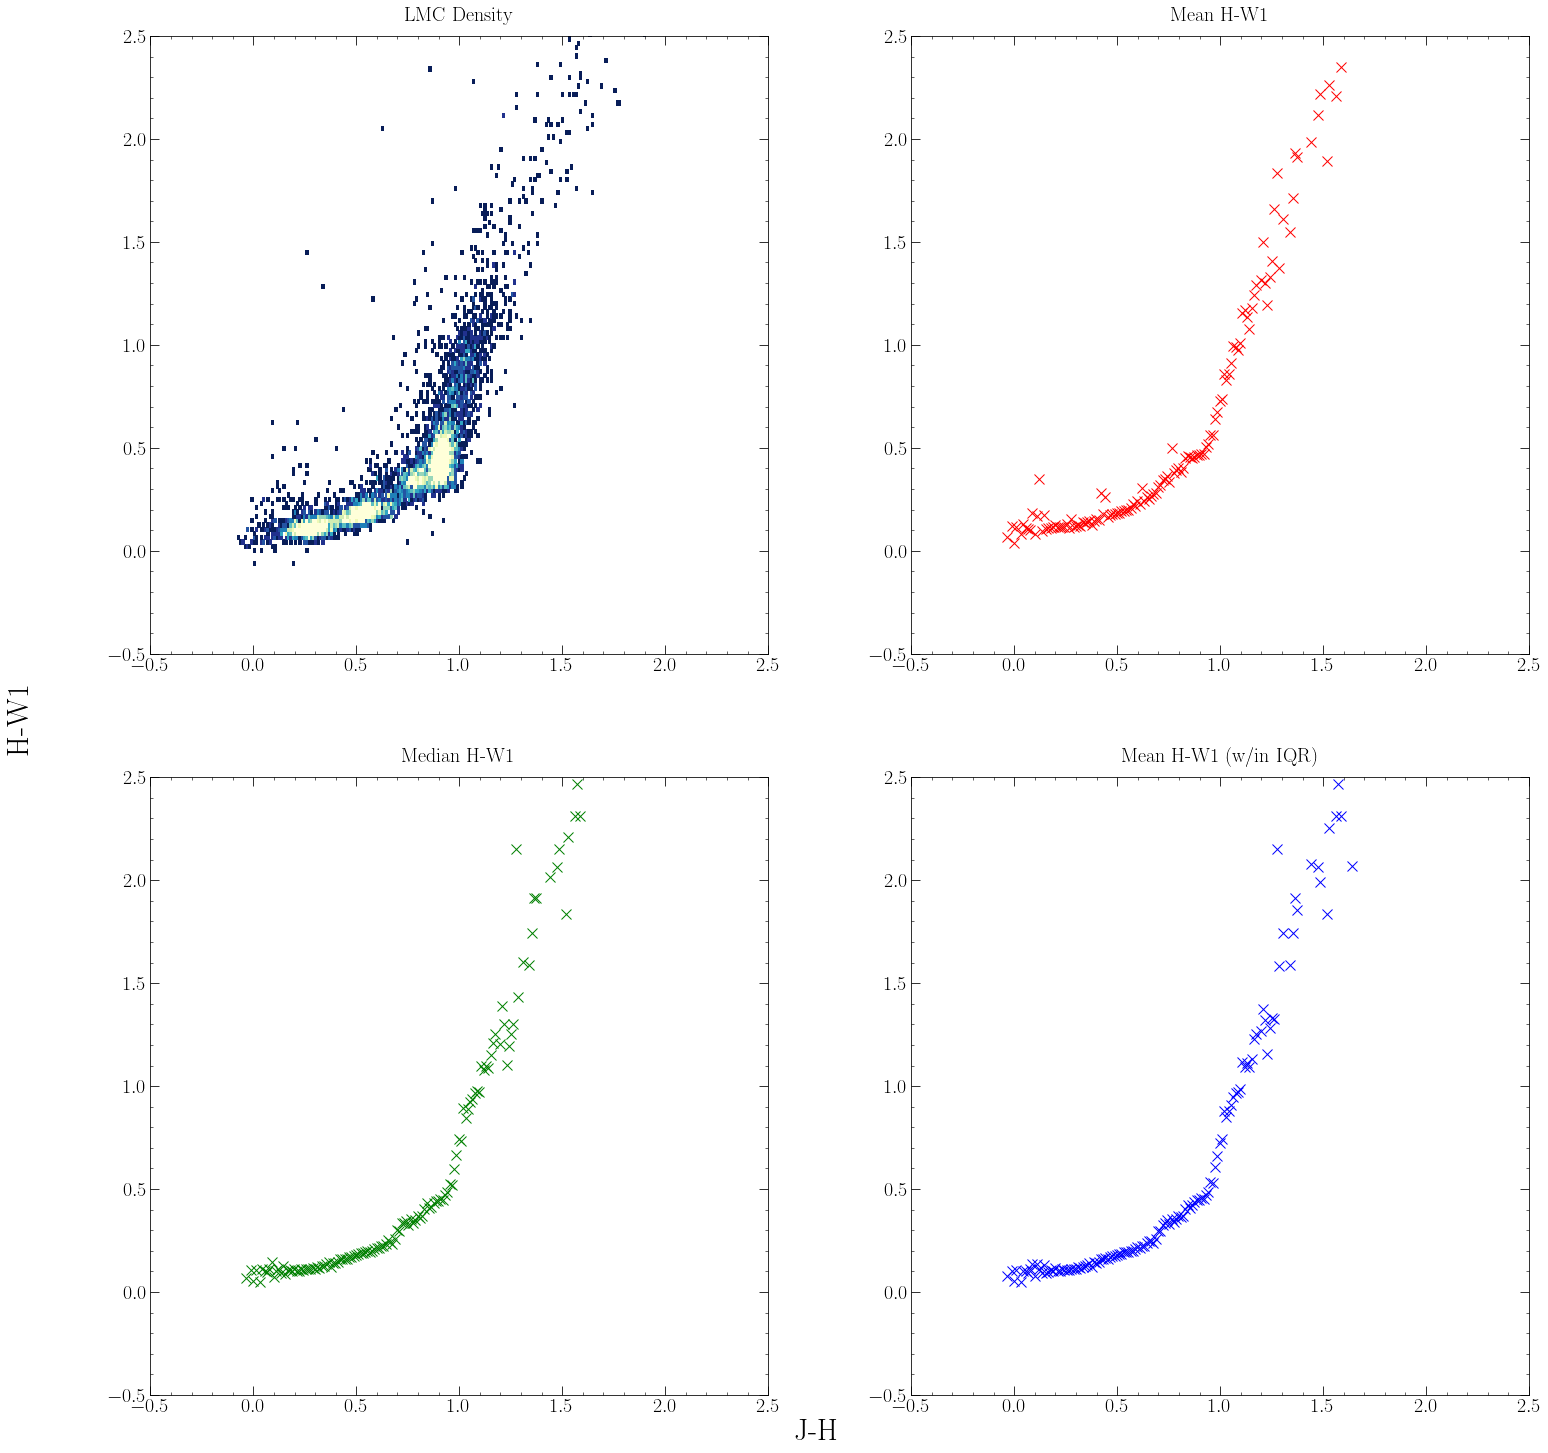

In [42]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(25,25)


lmc_colcol = ax[0,0].hist2d(jh, hw1, 
                    cmap='YlGnBu_r', vmin=1, vmax=10,
                    bins=bins, cmin=1)

ax[0,0].set_aspect(1)
ax[0,0].set_title('LMC Density', fontsize=20)
ax[0,0].set_xlim(-0.5, 2.5)
ax[0,0].set_ylim(-0.5, 2.5);

mean_cols = [np.mean(hw1[np.where((jh >= lmc_colcol[1][nz][i]) & (jh < lmc_colcol[1][nz][i+1]))]) for i in range(len(lmc_colcol[1][nz]) -1)]
ax[0,1].set_aspect(1)
ax[0,1].scatter(lmc_colcol[1][nz][:-1], mean_cols, s=100, c='r', marker='x', linewidth=1)
ax[0,1].set_xlim(-0.5, 2.5)
ax[0,1].set_ylim(-0.5, 2.5);
ax[0,1].set_title('Mean H-W1', fontsize=20)

med_cols = [np.median(hw1[np.where((jh >= lmc_colcol[1][nz][i]) & (jh < lmc_colcol[1][nz][i+1]))]) for i in range(len(lmc_colcol[1][nz]) -1)]
ax[1,0].set_aspect(1)
ax[1,0].scatter(lmc_colcol[1][nz][:-1], med_cols, s=100, c='g', marker='x', linewidth=1)
ax[1,0].set_xlim(-0.5, 2.5)
ax[1,0].set_ylim(-0.5, 2.5);
ax[1,0].set_title('Median H-W1', fontsize=20)

ax[1,1].scatter(lmc_colcol[1][:-1][nz], running_mean, s=100, c='b', marker='x', linewidth=1)
ax[1,1].set_aspect(1)
ax[1,1].set_xlim(-0.5, 2.5)
ax[1,1].set_ylim(-0.5, 2.5);
ax[1,1].set_title('Mean H-W1 (w/in IQR)', fontsize=20)

#plt.colorbar(lmc_colcol[3], ax=ax, fraction=0.01375);
fig.text(0.05, 0.5, 'H-W1', rotation='vertical', verticalalignment='center', fontsize=30);
fig.text(0.5, 0.1, 'J-H', horizontalalignment='center', fontsize=30);

In [43]:
xs = lmc_colcol[1][:-1][nz]
sqr_spline = spline(xs, running_mean, k=2)
cube_spline = spline(xs, running_mean, k=3)
con = spline(xs, running_mean, s=1.1)

In [44]:
xx = np.linspace(0,5,1000)

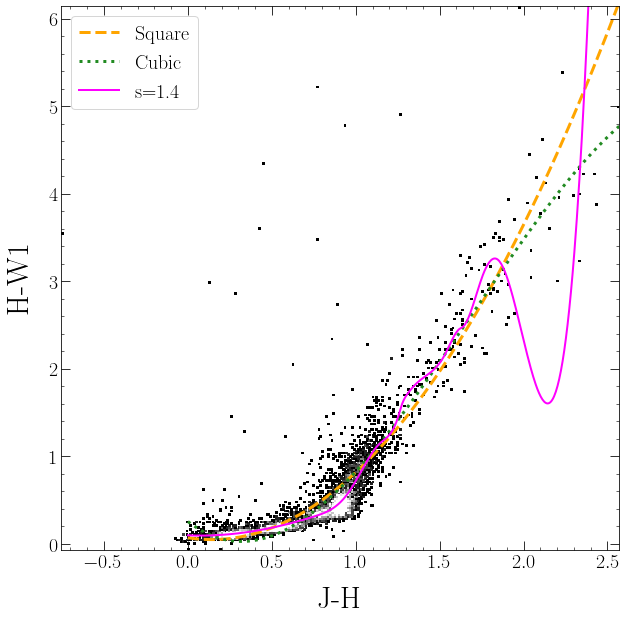

In [45]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)

ax.set_xlim(-0.5, 5)
ax.set_ylim(-0.5, 20)
ax.set_xlabel('J-H')
ax.set_ylabel('H-W1')

ax.hist2d(jh, hw1, 
            cmap='Greys_r', vmin=1, vmax=10,
            bins=300, cmin=1)

ax.plot(xx, sqr_spline(xx), linewidth=3, linestyle='--', label='Square', c='orange')
ax.plot(xx, cube_spline(xx), linewidth=3, linestyle=':', label='Cubic', c='forestgreen')
ax.plot(xx, con(xx), linewidth=2, label='s=1.4', c='fuchsia')
#ax.scatter(xs, running_mean, c='black', s=5, label='Means');
ax.legend(loc='best');

In [46]:
###F160W to H conversion (using color conversions from https://arxiv.org/pdf/1109.6893.pdf (Dalcanton, 2018))
def convert_to_JH(f110w,f160w):
    j_h = 0.9418 + 0.841*(f110w-f160w-1.0) - 0.9053*(f110w-f160w-1.0)**2
    return j_h
def HST_to_2MASS(f110w,f160w):
    f160w_h = 0.2031 + 0.401*(convert_to_JH(f110w,f160w) - 0.9) + 0.3498*(convert_to_JH(f110w,f160w) - 0.9)**2
    h = f160w - f160w_h
    j = h + convert_to_JH(f110w,f160w)
    return j,h

###Define J and H for ph_data sources and add to dataframe

j_mag, h_mag = HST_to_2MASS(phatter.F110W_VEGA.evaluate(), phatter.F160W_VEGA.evaluate())

phatter['J_Mag'], phatter['H_Mag'], phatter['J_H'] = j_mag, h_mag, j_mag - h_mag
phatter['J_H'] = np.nan_to_num(phatter.J_H.evaluate())


###Convert J-H to H-W1 using spline fit from LMC color locus

phatter['H_W1'] = con(phatter.J_H.evaluate())

phatter['W1_Mag'] = phatter['H_Mag'] - phatter['H_W1']

###Convert W1 magnitude to flux and add column to data
def m_to_flux(mag):
  result = 10**((mag - 22.5) / (-2.5))
  return result

phatter['W1_Flux'] = m_to_flux(phatter['W1_Mag'])

In [47]:
x1 = np.linspace(-1.0, 1.14, 1000)
x2 = np.linspace(1.16, 2.5, 1000)
y1 = np.repeat(19.48, 1000)
y2 = 2 * x2 + 17.18

In [48]:
xs = np.concatenate((x1,x2), axis=0)
ys = np.concatenate((y1,y2), axis=0)

In [49]:
xg1 = np.linspace(-1.0, 1.2, 1000)
xg2 = np.linspace(1.2, 2.5, 1000)
yg1 = np.repeat(19.28, 1000)
yg2 = 2 * xg2 + 16.88

In [50]:
gxs = np.concatenate((xg1,xg2), axis=0)
gys = np.concatenate((yg1,yg2), axis=0)

In [51]:
#Color cuts to PHATTER sample following criteria from Goldman, et al 2022

phatter.select('(((F160W_VEGA < 19.48) & (F110W_VEGA - F160W_VEGA < 1.15)) | '
               '((F110W_VEGA - F160W_VEGA >= 1.15) & (F160W_VEGA < 2 * (F110W_VEGA - F160W_VEGA) + 17.18))) &'
               '(J_H > 0.0) & (J_H < 1.75) & IR_GST', 
               name='COL_CUT')

In [52]:
index_colcut = phatter.INDEX.evaluate(selection='COL_CUT')
RA,DEC = phatter.RA.evaluate(selection='COL_CUT'), phatter.DEC.evaluate(selection='COL_CUT')

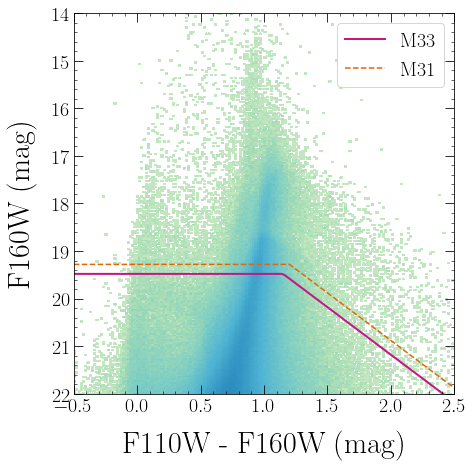

In [53]:
fig, ax = plt.subplots(1)

ax.set_aspect(3/8)


cmd = ax.hist2d(phatter.F110W_F160W.evaluate(selection='IR_GST'), phatter.F160W_VEGA.evaluate(selection='IR_GST'),
          bins=400,
          norm=mpl.colors.LogNorm(vmin=1e-2,vmax=1e5), 
          cmap='GnBu')
ax.plot(xs, ys, c='mediumvioletred', linestyle='-', linewidth=2, 
        label='M33' 
       )

ax.plot(gxs, gys, c='#E76404', linestyle='--', linewidth=1.5, 
        label='M31'
       )

ax.set_xlabel('F110W - F160W (mag)')
ax.set_ylabel('F160W (mag)')
ax.set_ylim(22,14)
ax.set_xlim(-0.5,2.5)

ax.legend(loc='best');

plt.savefig('./images/goldman_cut.png', bbox_inches='tight')

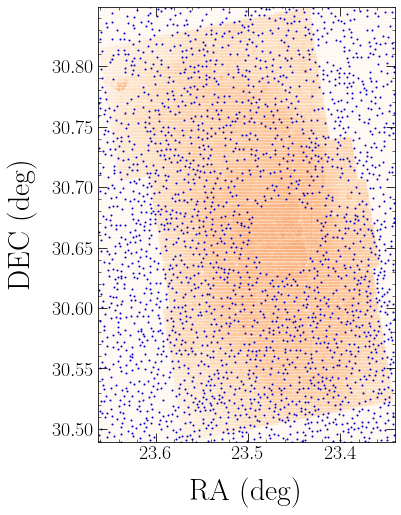

In [54]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,8)

ax.set_aspect(m33_ar)

cmap = plt.cm.get_cmap('Oranges')
hist = ax.hist2d(ra_gst, dec_gst, 
          bins=300,
          cmap=cmap,
          vmin=1, vmax=4e2,
          alpha=0.2
                 
         )
ax.scatter(unwise['ra'], unwise['dec'], s=1, c='mediumblue')
ax.set_xlim(phatter.RA.max(), phatter.RA.min())
ax.set_xticks([23.4, 23.5, 23.6])
ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)');

plt.savefig('./images/wise_overlay.png', bbox_inches='tight')

## Average Star Separation

In [55]:
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import SkyCoord
from astropy.table import Table

In [56]:
#Convert RA and DEC to SkyCoords to use astropy separation
sep_coords = SkyCoord(RA, DEC, unit='deg')

In [57]:
#Astropy find nearest neighbor, nth=2 to avoid matching stars to themselves
closest = match_coordinates_sky(sep_coords, sep_coords, nthneighbor=2)

In [58]:
closest

(array([   647,    593,     12, ..., 118256, 118624, 119007]),
 <Angle [7.80278115e-05, 7.06590794e-05, 6.06773841e-04, ...,
         2.51584959e-04, 2.59730264e-04, 5.22345353e-04] deg>,
 <Quantity [1.36184222e-06, 1.23323358e-06, 1.05902013e-05, ...,
            4.39098589e-06, 4.53314827e-06, 9.11664623e-06]>)

In [59]:
dist3d = np.array(closest[2])

In [60]:
sep2d = np.array(closest[1].to('arcsec'))

In [61]:
mean_sep = np.mean(sep2d)

In [62]:
F160W = phatter.F160W_VEGA.evaluate(selection='COL_CUT')

M = [18, 18.25, 18.5, 18.75, 19, 19.25, 19.5]
mags = [np.where((F160W > M[i]) & (F160W <= M[i+1])) for i in range(len(M) - 1)]

In [63]:
m_mns = []
m_mds = []

for i in range(len(M) - 1):
    hist = np.histogram(sep2d[mags[i]], bins=50);
    
    peak = np.argmax(hist[0])
    m_mns.append(np.round_(np.mean(sep2d[mags[i]]), decimals=6))
    m_mds.append(np.round(hist[1][peak], decimals=6))

In [64]:
HW1 = phatter.H_W1.evaluate(selection='COL_CUT')

In [65]:
C = [0, 0.5, 0.55, 0.6, 
     0.65, 0.7, 0.75, 
     0.8, 0.85, 1.2]

colors = [np.where((HW1 > C[i]) & (HW1 <= C[i+1])) for i in range(len(C) - 1)]

In [66]:
c_mns = []
c_mds = []

for i in range(len(C) - 1):
    np.histogram(sep2d[colors[i]], bins=30);
    peak = np.argmax(hist[0])
    
    c_mns.append(np.round_(np.mean(sep2d[colors[i]]), decimals=5))
    c_mds.append(np.round(hist[1][peak], decimals=5))

In [67]:
mms = [str(M[i]) + '< M <=' + str(M[i+1]) for i in range(6)]

In [68]:
ccs = [str(C[i]) + '< J-H <=' + str(C[i+1]) for i in range(9)]

In [69]:
Table([mms, 
       m_mns, np.round(np.multiply(m_mns,3600), decimals=3), 
       m_mds, np.round(np.multiply(m_mds,3600), decimals=3)], 
      names=['F160W', 'Mean Sep (deg)', 'Mean Sep (arcsec)', 'Mode Sep (deg)', 'Mode Sep (arcsec)'])

<Table length=6>
     F160W      Mean Sep (deg) ... Mode Sep (deg) Mode Sep (arcsec)
     str15         float64     ...    float64          float64     
--------------- -------------- ... -------------- -----------------
  18< M <=18.25       1.313212 ...       0.851174          3064.226
18.25< M <=18.5       1.273742 ...        0.83498          3005.928
18.5< M <=18.75       1.254809 ...       0.693248          2495.693
  18.75< M <=19       1.273009 ...       0.622514           2241.05
  19< M <=19.25       1.284581 ...       0.592382          2132.575
19.25< M <=19.5       1.272757 ...       0.624223          2247.203

In [70]:
Table([ccs, 
       c_mns, np.round(np.multiply(c_mns,3600), decimals=3), 
       c_mds, np.round(np.multiply(c_mds,3600), decimals=3)], 
      names=['J-H', 'Mean Sep (deg)', 'Mean Sep (arcsec)', 'Mode Sep (deg)', 'Mode Sep (arcsec)'])

<Table length=9>
      J-H       Mean Sep (deg) ... Mode Sep (deg) Mode Sep (arcsec)
     str15         float64     ...    float64          float64     
--------------- -------------- ... -------------- -----------------
   0< J-H <=0.5        1.30723 ...        0.62422          2247.192
0.5< J-H <=0.55        1.30833 ...        0.62422          2247.192
0.55< J-H <=0.6         1.2858 ...        0.62422          2247.192
0.6< J-H <=0.65        1.23699 ...        0.62422          2247.192
0.65< J-H <=0.7        1.24481 ...        0.62422          2247.192
0.7< J-H <=0.75        1.24785 ...        0.62422          2247.192
0.75< J-H <=0.8        1.19844 ...        0.62422          2247.192
0.8< J-H <=0.85        1.21476 ...        0.62422          2247.192
0.85< J-H <=1.2        1.17225 ...        0.62422          2247.192

## Matching Process

In [71]:
###unWISE RA and DEC
xu, yu = np.array(unwise['ra']), np.array(unwise['dec'])

In [72]:
ceil((np.max(xu) - np.min(xu)) / (5/3600)), ceil((np.max(yu) - np.min(yu)) / (5/3600))

(232, 261)

In [73]:
ra_bins = np.linspace(np.min(xu), np.max(xu), 232)
dec_bins = np.linspace(np.min(yu), np.max(yu), 261)

In [74]:
histu,hx,hy = np.histogram2d(xu, yu, bins=[ra_bins, dec_bins])
indu = ri.get_indices(histu, xu, yu, x_bins=hx, y_bins=hy)

In [75]:
histp,hxx,hyy = np.histogram2d(RA,DEC, bins=[hx,hy])
indp = ri.get_indices(histp, RA,DEC, x_bins=hx, y_bins=hy)

In [76]:
hist_gst,_,_ = np.histogram2d(ra_gst, dec_gst, bins=[hx,hy])
indgst =  ri.get_indices(hist_gst, ra_gst, dec_gst, x_bins=hx, y_bins=hy)

In [77]:
indu[200:218]

array([14900,  9959, 22443, 11260, 18020, 24261,  3463,  5544,   864,
       13345, 20364, 18025, 15946, 10486, 24005,  3726,  5547,  2427])

In [78]:
uw = 14900
p, = np.where(indp == uw)
uu, = np.where(indu == uw)
uu, p[:5]

(array([200]), array([ 98205, 100666]))

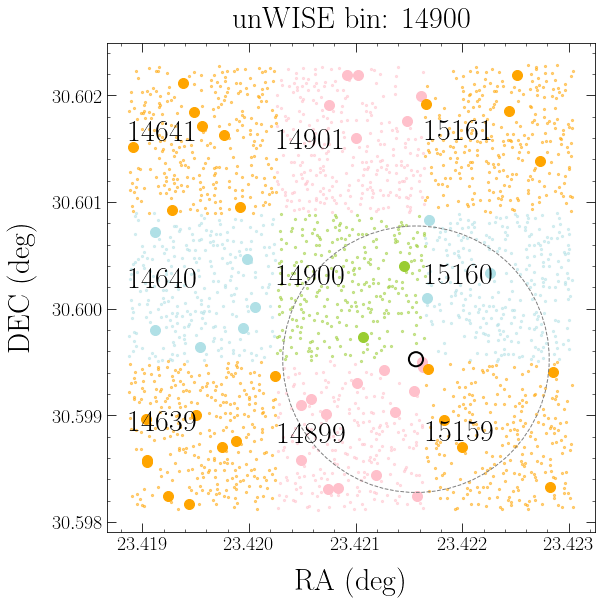

In [79]:
###Check that bin numbers are correctly aligned between the datasets
fig, ax = plt.subplots(1)
fig.set_size_inches(9,9)

bins = 261

ax.set_aspect(1)

ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')
ax.set_title('unWISE bin: {}'.format(uw), fontsize=30)

ax.scatter(unwise['ra'][uu], unwise['dec'][uu], 
           edgecolor='black', 
           facecolor='none', 
           marker='o',
           s=200,
           zorder=5,
           linewidths=2
          )
psf = patches.Circle((unwise['ra'][uu], unwise['dec'][uu]), 
                     radius=4.5/3600, 
                     edgecolor='gray', 
                     facecolor=(0,0,0,0),
                     linestyle='--',
                     linewidth=1)
ax.add_patch(psf)

bb = [uw, uw+1, uw-1, uw + bins - 1, uw - bins + 1, uw + bins, uw - bins, uw + bins - 2, uw - bins + 2]
cc = ['yellowgreen', 'pink', 'pink', 'powderblue', 'powderblue', 'orange', 'orange', 'orange', 'orange']

for i,bin in enumerate(bb):
    lox, = np.where(indgst == bb[i])
    ax.scatter(ra_gst[lox], dec_gst[lox],
               color=cc[i], s=5, alpha=0.5)
    
    final, = np.where(indp == bb[i])
    ax.scatter(RA[final], DEC[final],
               color=cc[i], s=100)

    ax.text(np.min(ra_gst[lox]), np.mean(dec_gst[lox]),
                str(bin), fontsize=30)
    

    
plt.savefig('./images/bin_visuals.png', bbox_inches='tight')

In [80]:
w1f = phatter.W1_Flux.evaluate(selection='COL_CUT')

<string>:1: RuntimeWarning: overflow encountered in power


In [81]:
col = phatter.F110W_F160W.evaluate(selection='COL_CUT')

In [82]:
f160 = phatter.F160W_VEGA.evaluate(selection='COL_CUT')
w1m = phatter.W1_Mag.evaluate(selection='COL_CUT')

In [83]:
col1 = phatter.F814W_VEGA.evaluate(selection='COL_CUT') - phatter.F110W_VEGA.evaluate(selection='COL_CUT')
col2 = phatter.F110W_VEGA.evaluate(selection='COL_CUT') - phatter.F160W_VEGA.evaluate(selection='COL_CUT')
col3 = phatter.F160W_VEGA.evaluate(selection='COL_CUT') - phatter.W1_Mag.evaluate(selection='COL_CUT')

In [84]:
nn, = np.where((np.isnan(col1) == False) & (np.isnan(col2) == False) & (np.isnan(col3) == False))

In [85]:
reasonable, = np.where(col3[nn] < 2.0)

In [86]:
test, = np.where(phatter.W1_Mag.evaluate(selection='COL_CUT')[nn] > 19.5)

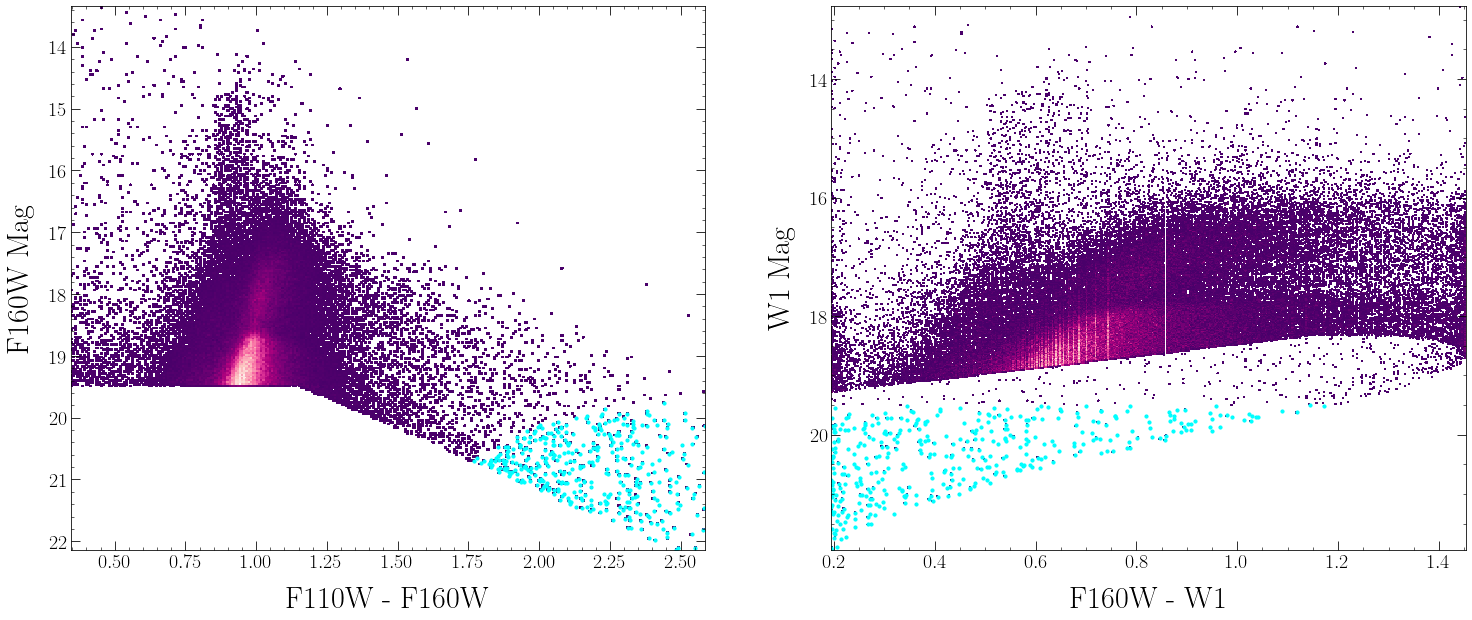

In [87]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(25,10)

ax[0].hist2d(col2[nn], phatter.F160W_VEGA.evaluate(selection='COL_CUT')[nn], bins=300, cmin=1);
ax[0].scatter(col2[nn][test], phatter.F160W_VEGA.evaluate(selection='COL_CUT')[nn][test], s=10, c='cyan');
ax[0].set_xlabel('F110W - F160W')
ax[0].set_ylabel('F160W Mag')
#ax.set_xlim(0,2)
#ax.set_ylim(12,22)
ax[0].invert_yaxis();

ax[1].hist2d(col3[nn], phatter.W1_Mag.evaluate(selection='COL_CUT')[nn], bins=500, cmin=1);
ax[1].scatter(col3[nn][test], phatter.W1_Mag.evaluate(selection='COL_CUT')[nn][test], s=10, c='cyan');
ax[1].set_xlabel('F160W - W1')
ax[1].set_ylabel('W1 Mag')
#ax[1].set_xlim(5, -10)
#ax[1].set_ylim(5, 40)
ax[1].invert_yaxis();

In [88]:
ar_length = len(RA)
flux_fracs = np.full(ar_length, -999.9)
dists = np.full(ar_length, -999.9)
uw_matches = np.full(ar_length, -999)

In [89]:
match_ids = np.full(len(RA), '****************')

In [90]:
ph_index = np.arange(0, len(RA), 1)

In [91]:
%%time
###Number of bins should match the number chosen for reverse indices above
bins = 261

for i,source in enumerate(unwise):
    ###Get bin of unWISE source
    wb = indu[i]
    ###Get indices of PHATTER sources in the same or nearby bins
    loc, = np.where((indp >= wb - bins) & (indp <= wb + bins))
     
    ###Get the distance between each PHATTER source and the unWISE source
    dist = np.sqrt( ((RA[loc] - unwise['ra'][i])*np.cos(unwise['dec'][i] * np.pi / 180))**2 
                   + (DEC[loc] - unwise['dec'][i])**2)
    
    ###Get indices of PHATTER sources where the above distance is 4.5" or less                                                                                                                                              
    matched, = np.where(dist <= 4.5/3600)
    ###Add the objid of the unWISE source 
    ###to the array of match IDs at the index of each matched PHATTER source
    if len(matched) != 0:
        indices = ph_index[loc][matched]
        #ph_ind.append(ind)
        match_ids[indices] = unwise['unwise_objid'][i]
        
        ###Total flux of all matches for WISE source [i], ranking added in case not all matches are used                                                                
        total_flux = np.sum(w1f[indices])#[ranked][::-1])
        ###Fraction of the W1 flux of every HST source over the total flux of all HST matches to WISE source [i]                                                               
        flux_frac = w1f[indices] / total_flux
        ###Adds all matching data to appropriate arrays                                                                                                                                            
        dists[indices] = dist[matched]     
        flux_fracs[indices] = flux_frac
        uw_matches[matched] = i

CPU times: user 317 ms, sys: 4.1 ms, total: 321 ms
Wall time: 323 ms


In [92]:
match, = np.where(match_ids != '****************')

In [93]:
df,ff = dists[match] / (mean_sep/3600), flux_fracs[match]

In [94]:
ones, = np.where(ff == 1.0)
not_ones, = np.where(ff != 1.0)
len(ones), len(not_ones)

(23, 17543)

0.50544773322947 0.6403375643011988


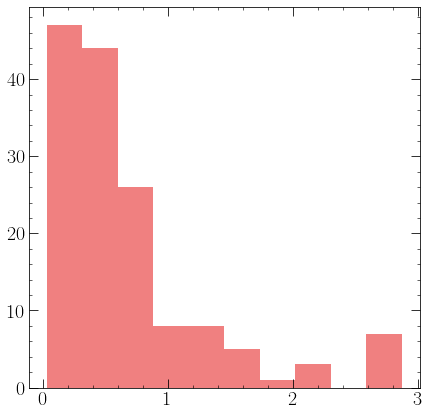

In [95]:
best_matches, = np.where(ff[not_ones] >= 0.75
                        )
plt.hist(df[not_ones][best_matches], bins=10);
print(np.median(df[not_ones][best_matches]), np.std(df[not_ones][best_matches]))

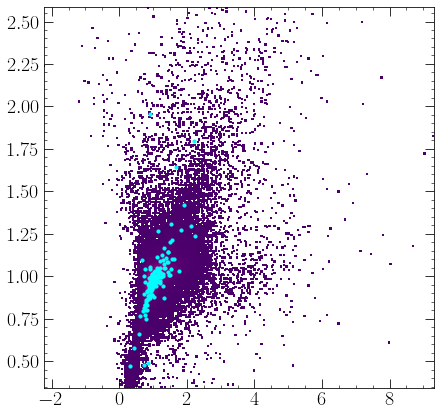

In [96]:
fig, ax = plt.subplots(1)

ax.hist2d(col1[nn], col2[nn], bins=300, cmin=1);
ax.scatter(col1[not_ones][best_matches], col2[not_ones][best_matches], s=10, c='cyan')

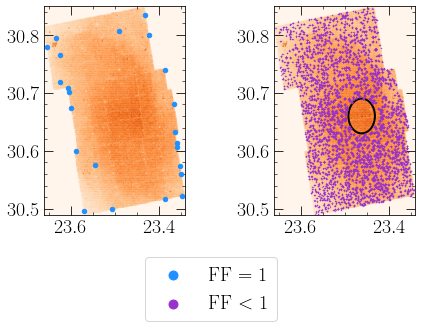

In [97]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(6,6)
fig.tight_layout(w_pad=5)

ax[0].set_aspect(m33_ar)
ax[1].set_aspect(m33_ar)

ax[0].scatter(RA[match][ones], DEC[match][ones], s=20, c='dodgerblue', zorder=10);
ax[0].hist2d(ra_gst, dec_gst, bins=300, density=True, cmap='Oranges', alpha=0.3);
ax[0].invert_xaxis()

ax[1].scatter(RA[match][not_ones], DEC[match][not_ones], s=0.1, c='darkorchid', zorder=10)
ax[1].hist2d(ra_gst, dec_gst, bins=300, density=True, cmap='Oranges', alpha=0.3);
ctr = patches.Circle((23.4625, 30.66), radius=0.03, edgecolor='black', facecolor=(0,0,0,0), linewidth=2)
ax[1].add_patch(ctr)
ax[1].invert_xaxis()

ax[0].scatter([0], [0], s=20, c='dodgerblue', zorder=10, label='FF = 1')
ax[0].scatter([0], [0], s=20, c='darkorchid', zorder=10, label='FF $<$ 1')
fig.legend(loc='lower center');

In [98]:
c_scales = [unwise['flux_1'][uw_matches][not_ones],
            unwise['dflux_1'][uw_matches][not_ones],
            unwise['fracflux_1'][uw_matches][not_ones],
            unwise['fluxlbs_1'][uw_matches][not_ones],
            unwise['fwhm_1'][uw_matches][not_ones],
            unwise['rchi2_1'][uw_matches][not_ones],
            phatter.F160W_ERR.evaluate(selection='COL_CUT')[match][not_ones],
            phatter.F160W_CROWD.evaluate(selection='COL_CUT')[match][not_ones],
            phatter.F160W_CHI.evaluate(selection='COL_CUT')[match][not_ones],
            phatter.F110W_ERR.evaluate(selection='COL_CUT')[match][not_ones],
            phatter.F110W_CROWD.evaluate(selection='COL_CUT')[match][not_ones],
            phatter.F110W_CHI.evaluate(selection='COL_CUT')[match][not_ones]]

titles = ['W1 Flux', 'dflux\_1', 'fracflux\_1', 
          'fluxlbs\_1', 'fwhm\_1', 'rchi2\_1',
          'F160W\_ERR', 'F160W\_CROWD', 'F160W\_CHI', 
          'F110W\_ERR', 'F110W\_CROWD', 'F110W\_CHI']

orders = [-1,-1,-1,
         -1,1,-1,
         1,1,1,
         1,1,1]

vmxs = [1000, 20, 1.0,
      1000, 2.635, 50,
      0.05, 1., 5,
      0.05, 1., 5]

vmns = [100, 9, 0.75,
       0, 2.618, 5,
       0, 0, 0,
       0, 0, 0]

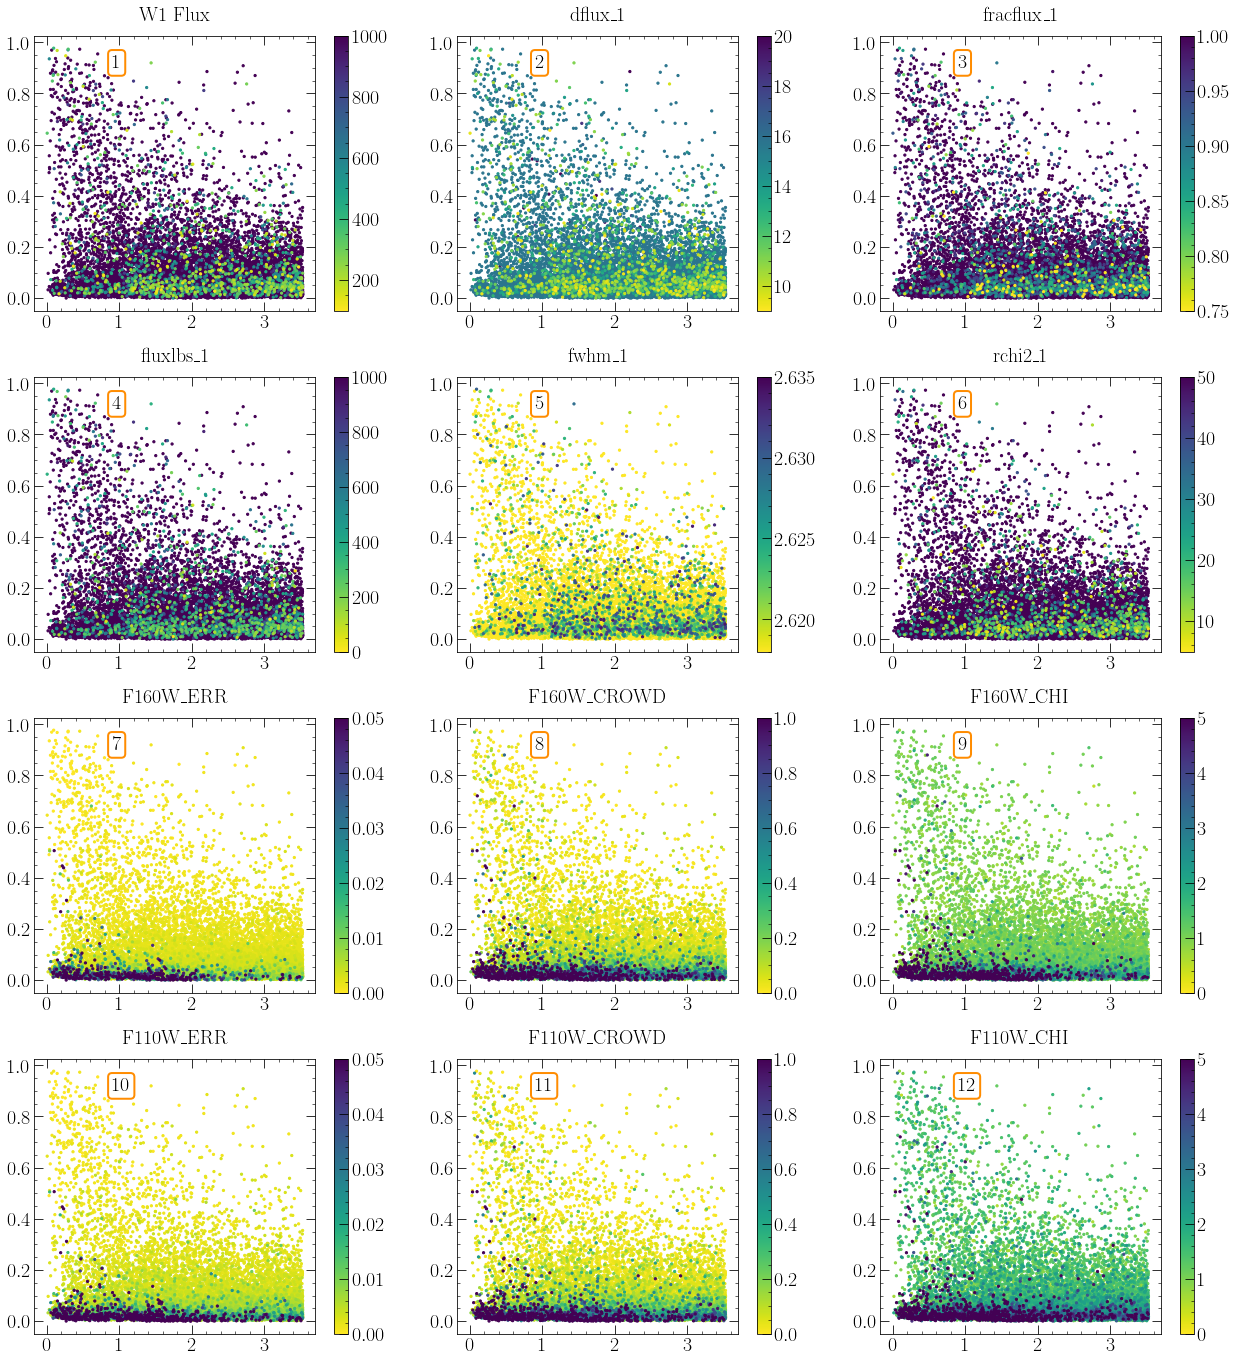

In [99]:
fig, axs = plt.subplots(4,3)
fig.tight_layout(h_pad=-0.5, w_pad=-1.5)
fig.set_size_inches(19, 20)

cmap = plt.cm.get_cmap('viridis_r')

for i,ax in enumerate(axs.ravel()):
    ss = np.argsort(c_scales[i])[::orders[i]]
    plot = ax.scatter(df[not_ones][ss], ff[not_ones][ss], 
                      c=c_scales[i][ss], cmap=cmap, 
                      s=5,
                      vmax=vmxs[i],
                      vmin=vmns[i])
    
    ax.set_aspect(np.max(df))
    ax.set_title(titles[i], fontsize=20);
    
    plotnum_text = ax.text(0.9, 0.9, str(i+1),
                       fontsize=20, fontweight='bold',
                       bbox=dict(boxstyle='round, pad=0.2', fc='white', ec='darkorange', linewidth=2))

    cbar = fig.colorbar(plot, ax=ax);
    
plt.savefig('./images/ff_df_plots.png', bbox_inches='tight')

In [100]:
n = 12
###Get the first n unwise object IDs for sources that have matches
first_n = np.unique(match_ids[match][not_ones])[n:2*n]

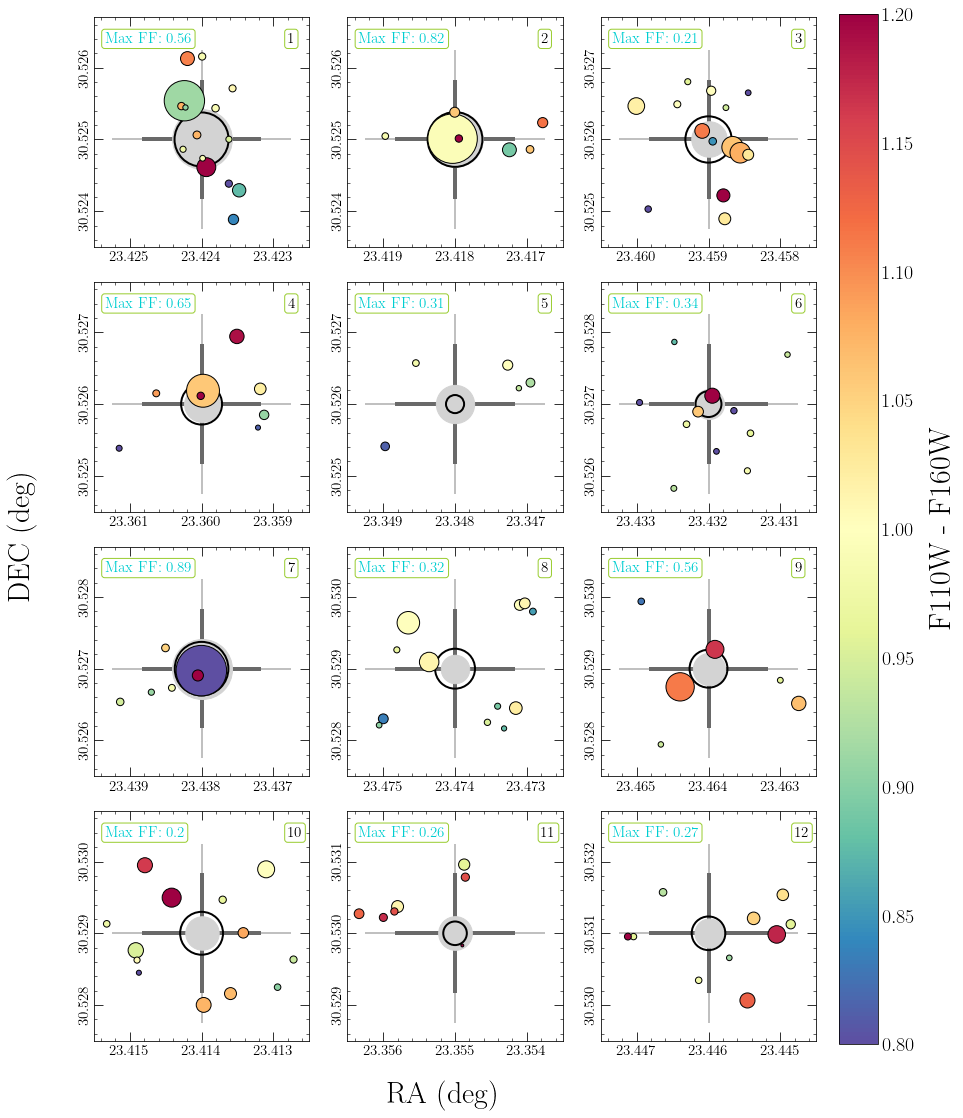

In [101]:
fig, axs = plt.subplots(4,3, figsize=(11,15))
fig.tight_layout(h_pad=0, w_pad=-1)


for i,ax in enumerate(axs.ravel()[:n]):
 ob, = np.where(unwise['unwise_objid'] == first_n[i])
 ph, = np.where(match_ids == first_n[i])
    
 match_flux = w1f[ph]
 total_flux = np.sum(w1f[ph])
 wise_flux = unwise['flux_1'][ob]
 colors_match = col[ph]
 cmh = cm.get_sub_cmap('Spectral_r', 0.0, 1.0)
 ordered = np.argsort(match_flux)[::-1]
 max_ff = (match_flux[ordered][0] / total_flux).round(2)
    
 ax.set_aspect(1)   

 ax.errorbar(unwise['ra'][ob], unwise['dec'][ob], 
              xerr=(4.5/3600), yerr=(4.5/3600), 
            color='silver', 
            linewidth=2)
 ax.errorbar(unwise['ra'][ob], unwise['dec'][ob], 
              xerr=(3/3600), yerr=(3/3600), 
            color='dimgrey', 
            linewidth=4)
 ax.scatter(unwise['ra'][ob], unwise['dec'][ob], 
           s=total_flux, 
           edgecolors='black', 
           linewidth=2, 
           facecolors='none', 
           marker='o',  
           label='Total Flux of Matches', 
           zorder=6)
 wplot = ax.scatter(unwise['ra'][ob], unwise['dec'][ob], 
           s=wise_flux,
           c='lightgrey',
           label='WISE Source', 
           zorder=5)
 cplot = ax.scatter(RA[ph], 
                   DEC[ph], 
                     s=match_flux, 
                     edgecolors='black', 
                     c=colors_match, 
                     cmap=cmh, 
                     vmin=0.8, vmax=1.2, 
                     label='HST Matches', 
                     zorder=7) 
 
 x,y = unwise['ra'][int(ob)], unwise['dec'][int(ob)]
 ax.set_xlim(x+0.0015, x-0.0015)
 ax.set_xticks([x-0.001, x, x+0.001])
 ax.set_xticklabels(["{:.3f}".format(x-0.001),"{:.3f}".format(x),"{:.3f}".format(x+0.001)], ha='center')
 ax.set_ylim(y-0.0015, y+0.0017)
 ax.set_yticks([y-0.001, y, y+0.001])
 ax.set_yticklabels(["{:.3f}".format(y-0.001),"{:.3f}".format(y),"{:.3f}".format(y+0.001)], va='center')
 ax.tick_params(axis='x',labelsize=15)
 ax.tick_params(axis='y',labelsize=15, rotation=90)


 maxf_text = ax.text(x+0.00135, y+0.00135, 'Max FF: ' + str(max_ff), 
         fontsize=15, fontweight='bold', 
         color='darkturquoise', 
         bbox=dict(boxstyle='round, pad=0.2', fc='white', ec='yellowgreen', lw=1))
 
 plotnum_text = ax.text(x-0.0012, y+0.00135, str(i+1),
                       fontsize=15, fontweight='bold',
                       bbox=dict(boxstyle='round, pad=0.2', fc='white', ec='yellowgreen'))
# end of loop

hst_cax = fig.add_axes([1.0, 0.03, 0.05, 0.954])
hst_cbar = fig.colorbar(cplot, cax=hst_cax)
hst_cbar.ax.tick_params(which='both', size=0)
hst_cbar.set_label('F110W - F160W')

fig.text(0.5, -0.025, 'RA (deg)', horizontalalignment='center', fontsize=30);
fig.text(-0.05, 0.5, 'DEC (deg)', rotation='vertical', verticalalignment='center', fontsize=30);

plt.savefig('./images/cutout_plots.png', bbox_inches='tight')

## False Matches

In [435]:
shifts = np.array([-36, -24, -12, 12, 24, 36])
distances_shift = []
flux_fracs_shift = []
ras_shift = []
decs_shift = []
uw_ind = []
cols_shift = []

In [436]:
for j,shift in enumerate(shifts):
  ra_shift = unwise['ra'] + (shift/3600)
  d = []
  f = []
  ra = []
  dec = []
  uind = []
  color=[]

  for i,source in enumerate(unwise):                
    dd = np.sqrt( ((RA - ra_shift[i])*np.cos(unwise['dec'][i] * np.pi / 180))**2 + 
               (DEC - unwise['dec'][i])**2)
    matched, = np.where(dd <= 4.5/3600)
  
    if len(matched) != 0:
      total_flux = np.sum(w1f[matched])
      fff = w1f / total_flux

      d.append(dd[matched])
      f.append(fff[matched])
      ra.append(RA[matched])
      dec.append(DEC[matched])
      uind.append([i]*len(matched))
      color.append(col[matched])
        

  dds = [x for group in d for x in group]
  ffs = [x for group in f for x in group]
  ras = [x for group in ra for x in group]
  decs = [x for group in dec for x in group]
  inds = [x for group in uind for x in group]
  cols = [x for group in color for x in group]

  distances_shift.append(dds)
  flux_fracs_shift.append(ffs)
  ras_shift.append(ras)
  decs_shift.append(decs)
  uw_ind.append(inds)
  cols_shift.append(cols)

In [437]:
for j,shift in enumerate(shifts):
  dec_shift = unwise['dec'] + (shift/3600)
  d = []
  f = []
  ra = []
  dec = []
  uind = []
  color = []

  for i,source in enumerate(unwise):                
    dd = np.sqrt( ((RA - unwise['ra'][i])*np.cos(dec_shift[i] * np.pi / 180))**2 + 
               (DEC - dec_shift[i])**2)
    matched, = np.where(dd <= 4.5/3600)
  
    if len(matched) != 0:
      total_flux = np.sum(w1f[matched])
      fff = w1f / total_flux

      d.append(dd[matched])
      f.append(fff[matched])
      ra.append(RA[matched])
      dec.append(DEC[matched])
      uind.append([i]*len(matched))
      color.append(col[matched])
        

  dds = [x for group in d for x in group]
  ffs = [x for group in f for x in group]
  ras = [x for group in ra for x in group]
  decs = [x for group in dec for x in group]
  inds = [x for group in uind for x in group]
  cols = [x for group in color for x in group]

  distances_shift.append(dds)
  flux_fracs_shift.append(ffs)
  ras_shift.append(ras)
  decs_shift.append(decs)
  uw_ind.append(inds)
  cols_shift.append(cols)

In [438]:
d_shift = np.array([l for group in distances_shift for l in group])
f_shift = np.array([k for group in flux_fracs_shift for k in group])
c_shift = np.array([j for group in cols_shift for j in group])

In [439]:
false_ra = np.array([x for group in ras_shift for x in group])
false_dec = np.array([x for group in decs_shift for x in group])
false_uind = np.array([x for group in uw_ind for x in group])

In [440]:
false_not_ones, = np.where(f_shift != 1.0)

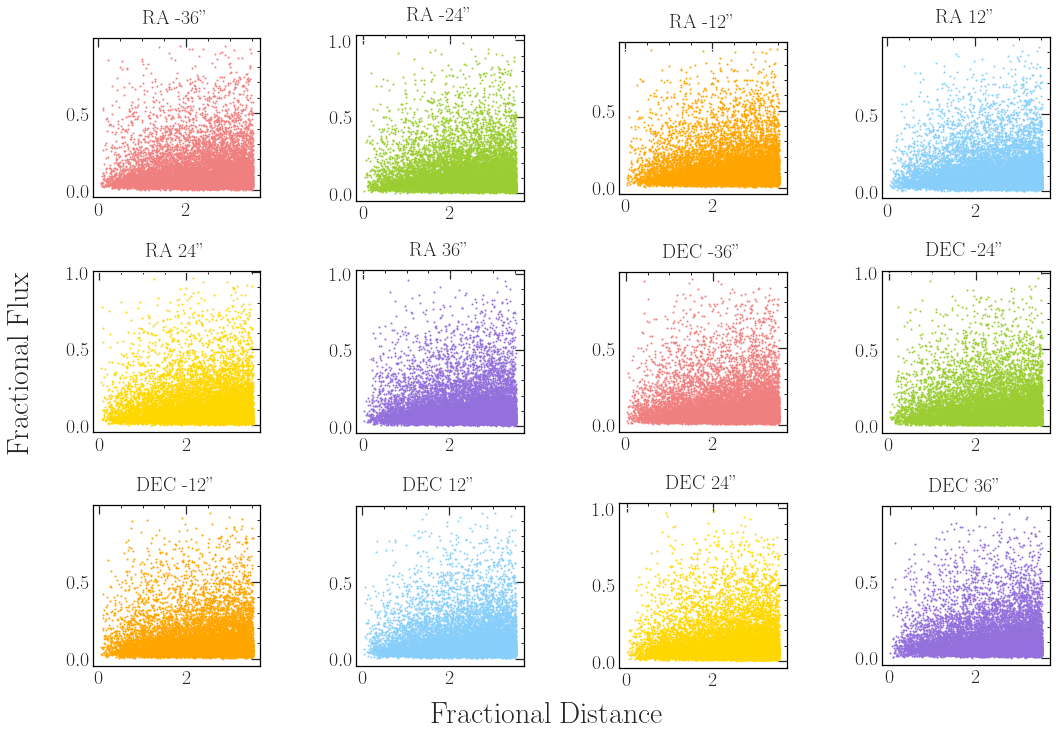

In [441]:
fig, axs = plt.subplots(3,4)
fig.tight_layout()
fig.set_size_inches(15, 10)

fig.text(0.5, 0.0, 'Fractional Distance', fontsize=30, horizontalalignment='center')
fig.text(0.0, 0.5, 'Fractional Flux', fontsize=30, rotation='vertical', verticalalignment='center')

arcs = [-36, -24, -12, 12, 24, 36, -36, -24, -12, 12, 24, 36]

for i,ax in enumerate(axs.ravel()):

  xx = np.array((distances_shift[i])) / (mean_sep/3600)
  yy = np.array(flux_fracs_shift[i])
  
  no, = np.where(yy != 1.0)
    
  ax.set_aspect(np.max(xx))
  ax.scatter(xx[no],yy[no], s=1, c=(cycle_colors*2)[i]);
  
  if i < 6:
    ax.set_title('RA ' + str(arcs[i]) + '\"', fontsize=20)
  else:
    ax.set_title('DEC ' + str(arcs[i]) + '\"', fontsize=20)

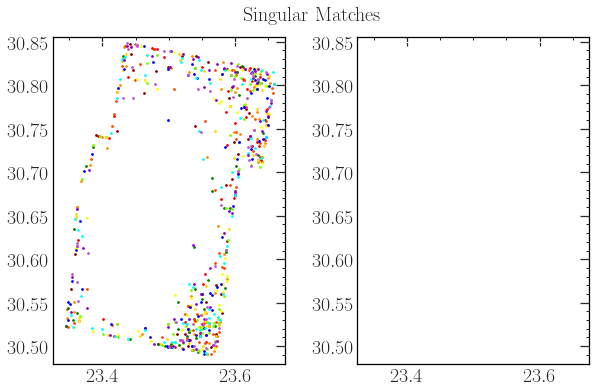

In [442]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,6)

ax[0].set_aspect(m33_ar)
ax[0].set_xlim(23.325, 23.675)
ax[0].set_ylim(30.48, 30.855)
cc = ['darkred', 'red', 'orangered', 'darkorange', 'gold', 'yellow', 
        'green', 'lawngreen', 'blue', 'aqua', 'darkviolet', 'mediumorchid']
for i in range(12):
  ff_false = np.array(flux_fracs_shift[i])
  
  one, = np.where(ff_false  == 1.0)
  ax[0].scatter(np.array(ras_shift[i])[one], np.array(decs_shift[i])[one], c=cc[i], s=3)

ones, = np.where(flux_fracs[match] == 1.0)
ax[1].set_aspect(m33_ar)
ax[1].set_xlim(23.325, 23.675)
ax[1].set_ylim(30.48, 30.855)
ax[1].scatter(RA[match][ones], DEC[match][ones]);

fig.text(0.5, 0.92, 'Singular Matches', ha='center', fontsize=20);

In [443]:
# Set up KDE for false match data
f_shift = f_shift[np.where(f_shift != 1.0)]
d_shift_frac = d_shift[np.where(f_shift!= 1.0)] / (mean_sep/3600)
false_data = np.array([d_shift_frac, f_shift])
false_kde = gaussian_kde(false_data)#, bw_method=0.2)
X,Y = np.meshgrid(np.linspace(0,1,200), np.linspace(0.025,0.2,200))
points = np.vstack([X.ravel(), Y.ravel()])

In [444]:
r_shift = 1/d_shift_frac**2

In [445]:
dd_obs, ff_obs = df[not_ones], ff[not_ones]

r_obs = 1 / dists[match][not_ones]**2
obs_wts = [r_obs* ff_obs]
obs_wts

[array([1.11235913e+08, 2.48941278e+07, 9.75994877e+06, ...,
        2.90677479e+06, 7.23325325e+04, 9.27485161e+03])]

In [446]:
obs_data = np.array([dd_obs, ff_obs])

obs_kde = gaussian_kde(obs_data)#, bw_method=0.2
                      #)

In [447]:
false_z = false_kde(points)

In [448]:
obs_z = obs_kde(points)

In [449]:
false_Z = np.reshape(false_z, X.shape)
norm_false_Z = false_Z / np.sum(false_Z)
obs_Z = np.reshape(obs_z, X.shape)
norm_obs_Z = obs_Z / np.sum(obs_Z)

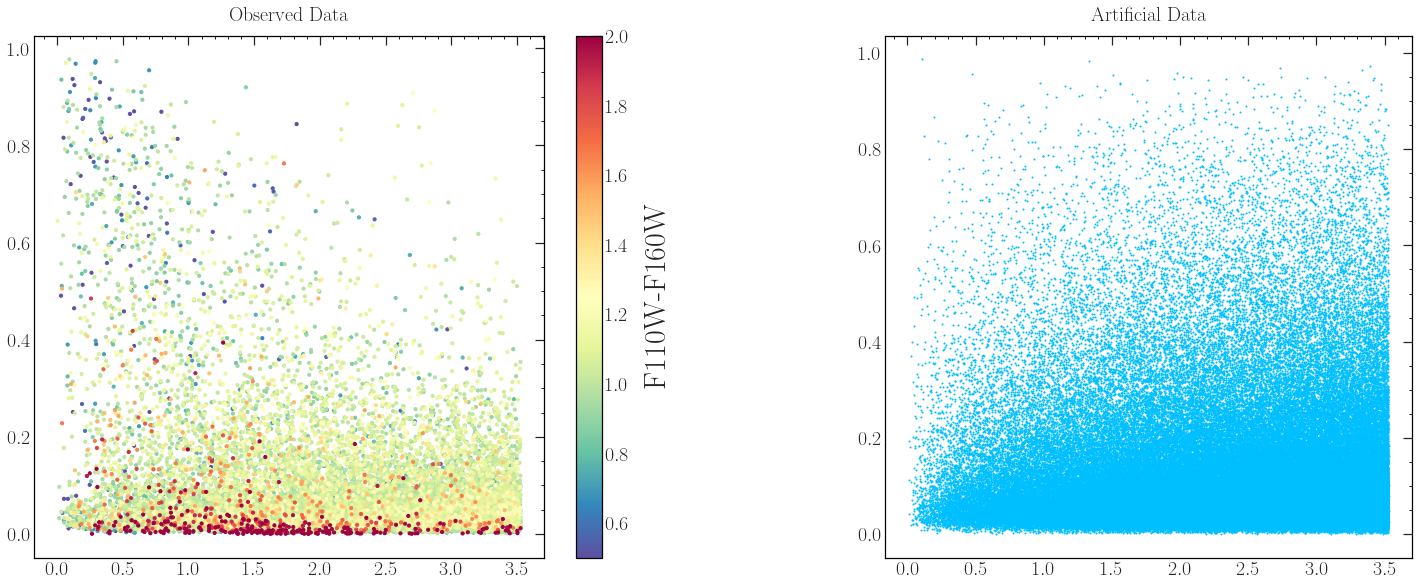

In [490]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches((13*8/5), 8)
fig.tight_layout(w_pad=10)

cmap_data = cm.get_sub_cmap('Spectral_r', 0.0, 1.0)
ss = np.argsort(col[match][not_ones])#[::-1]
obs = ax[0].scatter(dd_obs[ss], ff_obs[ss], 
                    s=10, 
                    c=col[match][not_ones][ss], cmap=cmap_data,
                    vmin=0.5, vmax=2.0)
ax[0].set_title('Observed Data', fontsize=20);

false = ax[1].scatter(d_shift_frac, f_shift, s=1, color='deepskyblue')
ax[1].set_title('Artificial Data', fontsize=20);
ax[1].set_aspect(np.max(dd_obs[ss]))

#plt.colorbar(false_smooth, ax=ax[0], label='Density');
plt.colorbar(obs, ax=ax[0], label='F110W-F160W');
#plt.savefig('./images/???.png', bbox_inches='tight')

In [451]:
x = np.linspace(0,1,1000)
x = x[1:]

for val in x:
    obs_hist = np.histogram2d(dd_obs, ff_obs, bins=bins)[0]
    art_hist = np.histogram2d(d_shift_frac, f_shift, bins=bins)[0]
    sub_hist = (obs_hist - val*art_hist) / np.sum(obs_hist - val*art_hist)
    check = np.sum(sub_hist, axis=1)
    if np.min(check) < 0.0:
        print(val.round(6))
        break
    else:
        pass

0.067067


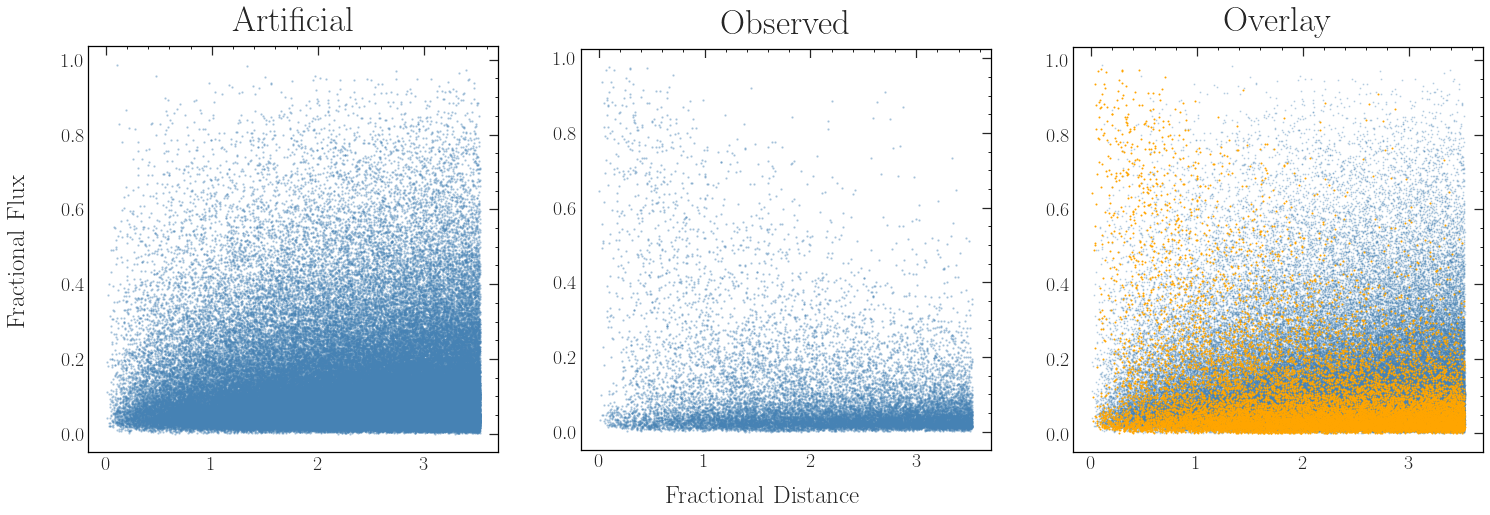

In [452]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(25,10)
x = [d_shift_frac, dd_obs]
y = [f_shift, ff_obs]
titles = ['Artificial', 'Observed', 'Overlay']

for i,ax in enumerate(axs):
    if i < 2:
        ax.scatter(x[i],y[i], s=2, c='steelblue', alpha=0.3)
        ax.set_aspect(np.max(x[i]))
        ax.set_title(titles[i])
    else:
        ax.set_aspect(np.max(x[0]))
        ax.set_title(titles[i])
        ax.scatter(x[0], y[0], s=1, c='steelblue', alpha=0.25)
        ax.scatter(x[1], y[1], s=1, c='orange')

fig.text(0.08, 0.5, 'Fractional Flux', rotation='vertical', verticalalignment='center', fontsize=25);
fig.text(0.5, 0.15, 'Fractional Distance', horizontalalignment='center', fontsize=25);

In [494]:
keep_o, = np.where(ff_obs >= 0.2)
keep_a, = np.where(f_shift >= 0.2)

In [495]:
ocdat = col[match][not_ones][keep_o]
oconditions = [(ocdat < 0.75), ((ocdat >= 0.75) & (ocdat < 0.85)), ((ocdat >= 0.85) & (ocdat < 0.95)), ((ocdat >= 0.95) & (ocdat < 1.05)), ((ocdat>=1.05) & (ocdat<1.3)), (ocdat>=1.3)]
ochoices = ['$110-160 < 0.75$', '$0.75 <=110-160< 0.85$', '$0.85 <=110-160< 0.95$', '$0.95 <=110-160< 1.05$', '$1.0 <=110-160< 1.25$', '$1.25 <=110-160$']

In [496]:
ocdat

array([1.043, 0.83 , 0.884, ..., 0.921, 0.966, 0.97 ])

In [497]:
acdat = c_shift[keep_a]
acond = [(acdat < 0.75), ((acdat >= 0.75) & (acdat < 0.85)), ((acdat >= 0.85) & (acdat < 0.95)), ((acdat >= 0.95) & (acdat < 1.05)), ((acdat>=1.05) & (acdat<1.3)), (acdat>=1.3)]
achoic = ['$110-160 < 0.75$', '$0.75 <=110-160< 0.85$', '$0.85 <=110-160< 0.95$', '$0.95 <=110-160< 1.05$', '$1.0 <=110-160< 1.25$', '$1.25 <=110-160$']

In [498]:
ohues = np.select(oconditions, ochoices)
ahues = np.select(acond, achoic)

In [499]:
od = {'df':dd_obs[keep_o],
      'ff':ff_obs[keep_o],
      'col':ocdat,
      'hue':ohues
     }
odf = pd.DataFrame(od)

In [501]:
ad = {'df':d_shift_frac[keep_a],
      'ff':f_shift[keep_a],
      'col':acdat,
      'hue':ahues
      }
adf = pd.DataFrame(ad)

In [502]:
odf.sort_values('hue', inplace=True)
adf.sort_values('hue', inplace=True)

In [530]:
#mpl.rcParams['axes.prop_cycle'] = cycler(color=['lime', 'greenyellow', 'yellow', 'orange', 'deepskyblue', 'crimson'])
mpl.rcParams['axes.prop_cycle'] = cycler(color=['lemonchiffon', 'lemonchiffon', 'lemonchiffon', 'lemonchiffon', 'deepskyblue', 'crimson'])

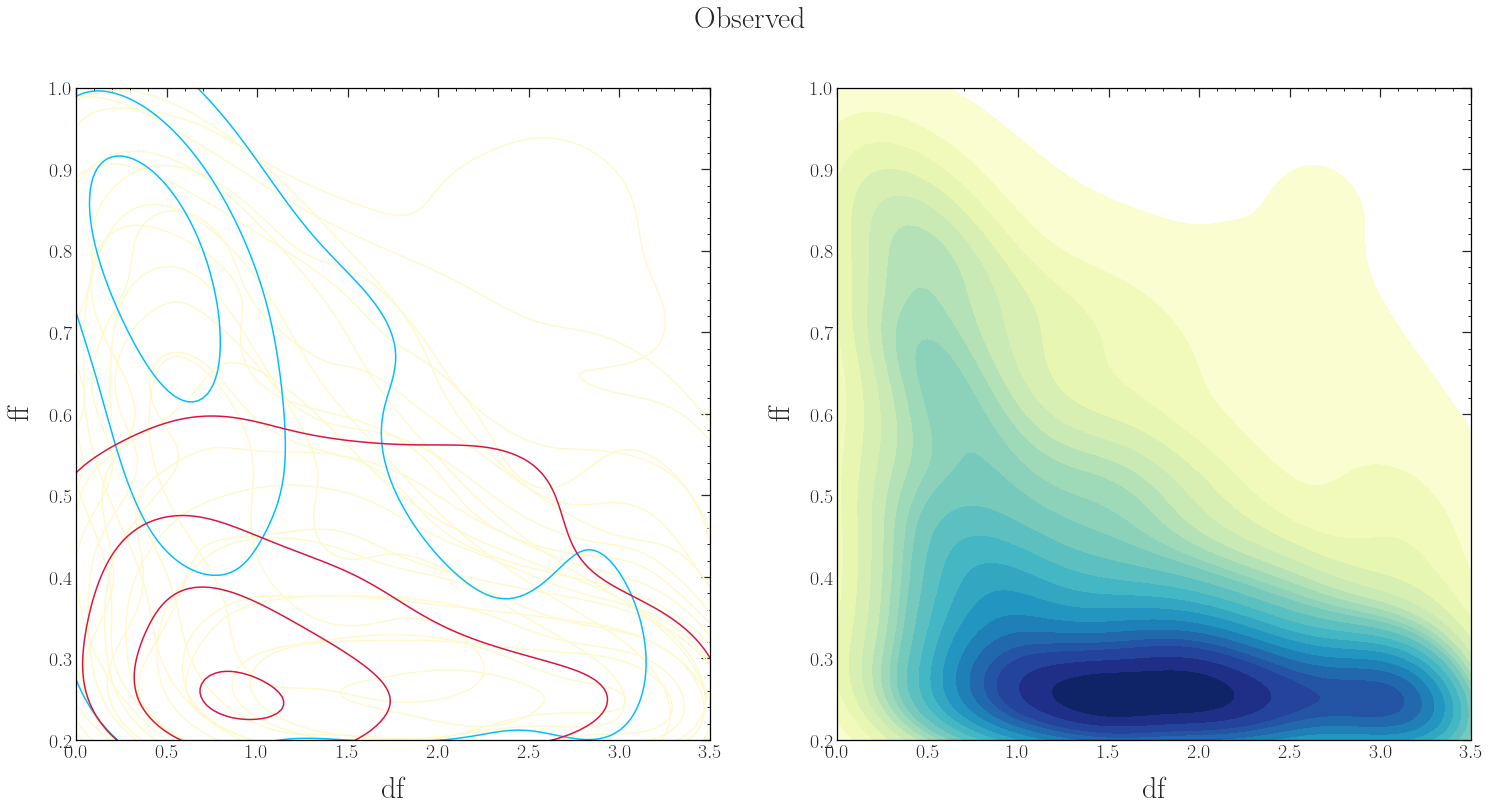

In [534]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(25,12)


ax1.set_xlim(0,3.5)
ax1.set_ylim(0.2,1)
sns.kdeplot(data=odf, ax=ax1, x='df', y='ff',
            levels=10,
            hue='hue', hue_order=['$0.75 <=110-160< 0.85$', '$0.85 <=110-160< 0.95$', '$0.95 <=110-160< 1.05$', '$1.0 <=110-160< 1.25$', '$110-160 < 0.75$', '$1.25 <=110-160$'],
            legend=False);

ax2.set_xlim(0,3.5)
ax2.set_ylim(0.2,1)
sns.kdeplot(data=odf, ax=ax2, x='df', y='ff',
            cmap='YlGnBu', cbar=False,
            fill=True, thresh=0.01, levels=20);

fig.text(0.5, 0.95, 'Observed', ha='center', fontsize=30);

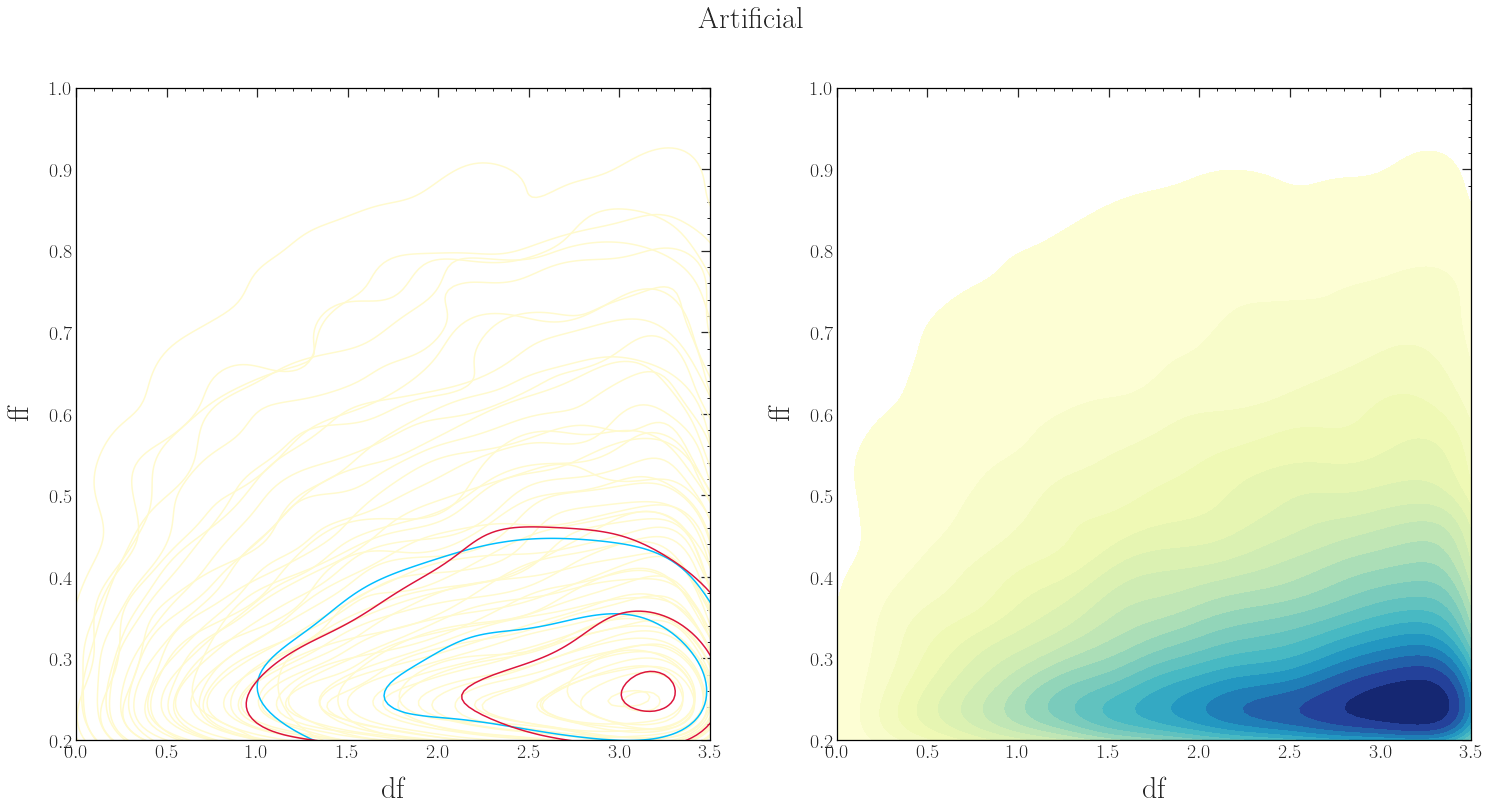

In [536]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(25,12)


ax1.set_xlim(0,3.5)
ax1.set_ylim(0.2,1)
sns.kdeplot(data=adf, ax=ax1, x='df', y='ff',
            levels=20,
            hue='hue', hue_order=['$0.75 <=110-160< 0.85$', '$0.85 <=110-160< 0.95$', '$0.95 <=110-160< 1.05$', '$1.0 <=110-160< 1.25$', '$110-160 < 0.75$', '$1.25 <=110-160$'],
            legend=False);

ax2.set_xlim(0,3.5)
ax2.set_ylim(0.2,1)
sns.kdeplot(data=adf, ax=ax2, x='df', y='ff',
            cmap='YlGnBu', cbar=False,
            fill=True, thresh=0.01, levels=20);

fig.text(0.5, 0.95, 'Artificial', ha='center', fontsize=30);

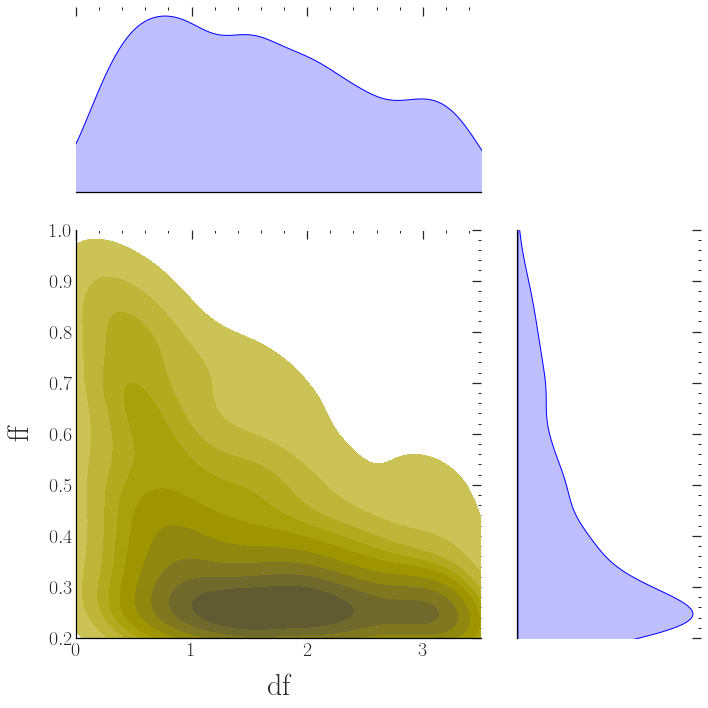

In [551]:
ob_plot = sns.jointplot(data=odf, x='df', y='ff', 
              #hue='hue', hue_order=['$0.75 <=110-160< 0.85$', '$0.85 <=110-160< 0.95$', '$0.95 <=110-160< 1.05$', '$1.0 <=110-160< 1.25$', '$110-160 < 0.75$', '$1.25 <=110-160$'],
              kind='kde',# bins=100,
              height=10, ratio=4,
              xlim=(0,3.5), ylim=(0.2,1),
              legend=False, 
              fill=True,
              marginal_kws=dict(color='blue')
             );

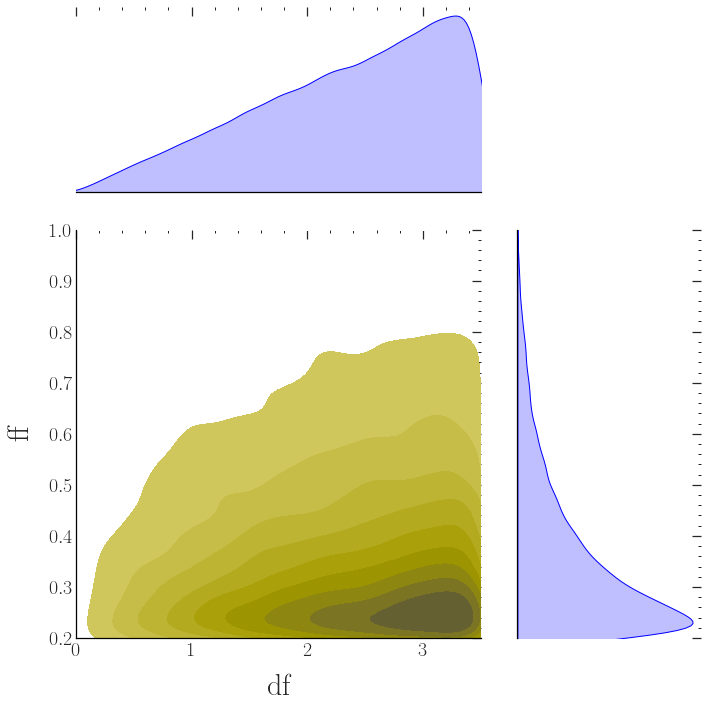

In [552]:
art_plot = sns.jointplot(data=adf, x='df', y='ff', 
              #hue='hue', hue_order=['$0.75 <=110-160< 0.85$', '$0.85 <=110-160< 0.95$', '$0.95 <=110-160< 1.05$', '$1.0 <=110-160< 1.25$', '$110-160 < 0.75$', '$1.25 <=110-160$'],
              kind='kde',# bins=100,
              height=10, ratio=4,
              xlim=(0,3.5), ylim=(0.2,1),
              legend=False, 
              fill=True,
              marginal_kws=dict(color='blue')
             );

In [555]:
type(ob_plot)

seaborn.axisgrid.JointGrid

In [529]:
fig = plt.figure(figsize=(20,6))

kde_plots = [norm_false_Z, norm_obs_Z, (norm_obs_Z - x*norm_false_Z)]
dedges = np.histogram(dd_obs, bins=bins, density=True)[1]
fedges = np.histogram(ff_obs, bins=bins, density=True)[1]

dhists = [d_shift_frac, dd_obs, np.sum(sub_hist, axis=1)]
fhists = [f_shift, ff_obs, np.sum(sub_hist, axis=0)]
titles = ['Artificial', 'Observed', 'Observed - ' + str(x) + 'xArtificial']
left = [0.0, 0.33, 0.66]

cmap_kde = cm.get_sub_cmap('viridis', 0.0, 1.0)
norm = mpl.colors.LogNorm(vmin=1e-5, vmax=1e-4)

cmaps = []

for i in range(3):
    ax = fig.add_axes([left[i], 0.0, 0.3, 0.8])
    smooth = ax.imshow(np.flipud(kde_plots[i]),
                      cmap=cmap_kde,
                            extent=[0,1,0,1], norm=norm)
    cmaps.append(smooth)
    
    hax1 = fig.add_axes([left[i] + 0.03, 0.81, 0.239, 0.16], sharex=ax)
    hax2 = fig.add_axes([left[i] + 0.274, 0.0, 0.05, 0.8], sharey=ax)
    hax1.tick_params(which='both', labelcolor='none')
    hax2.tick_params(which='both', labelcolor='none')
    hax1.set_title(titles[i], fontsize=20)
    
    
    
    if (i != 2):
        hax1.hist(dhists[i], bins=bins, density=True, color='limegreen')
        hax2.hist(fhists[i], orientation='horizontal', bins=bins, density=True, color='limegreen')
    else:
        hax1.bar(x=dedges[:-1], height=dhists[i], width=0.01, align='edge', color='limegreen')
        hax2.barh(y=fedges[:-1], width=fhists[i], height=0.01, align='edge', color='limegreen')
        
cax = fig.add_axes([1.01, 0.0, 0.025, 0.8])

plt.colorbar(cmaps[2], cax=cax);

fig.text(-0.025, 0.5, 'Fractional Flux', rotation='vertical', verticalalignment='center', fontsize=25);
fig.text(0.5, -0.15, 'Fractional Distance', horizontalalignment='center', fontsize=25);

plt.savefig('./images/kde_combo.png', bbox_inches='tight')

<ipython-input-529-6e71c10198f5>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kde_plots = [norm_false_Z, norm_obs_Z, (norm_obs_Z - x*norm_false_Z)]


ValueError: operands could not be broadcast together with shapes (2,) (200,200) 

<Figure size 1440x432 with 0 Axes>

## Catalog

In [ ]:
###Create table with index of the PHATTER data and the objid of the wise source it matched to

#objid_key = Table([phatter.INDEX.evaluate(), match_ids], names=['phatter_index', 'unwise_objid'])

In [123]:
#m, = np.where(objid_key['unwise_objid'] != '****************')

In [124]:
#objid_key[m].write('objid_key.csv')
